## Project 1: Gradient-based Algorithms and Differentiable Programming



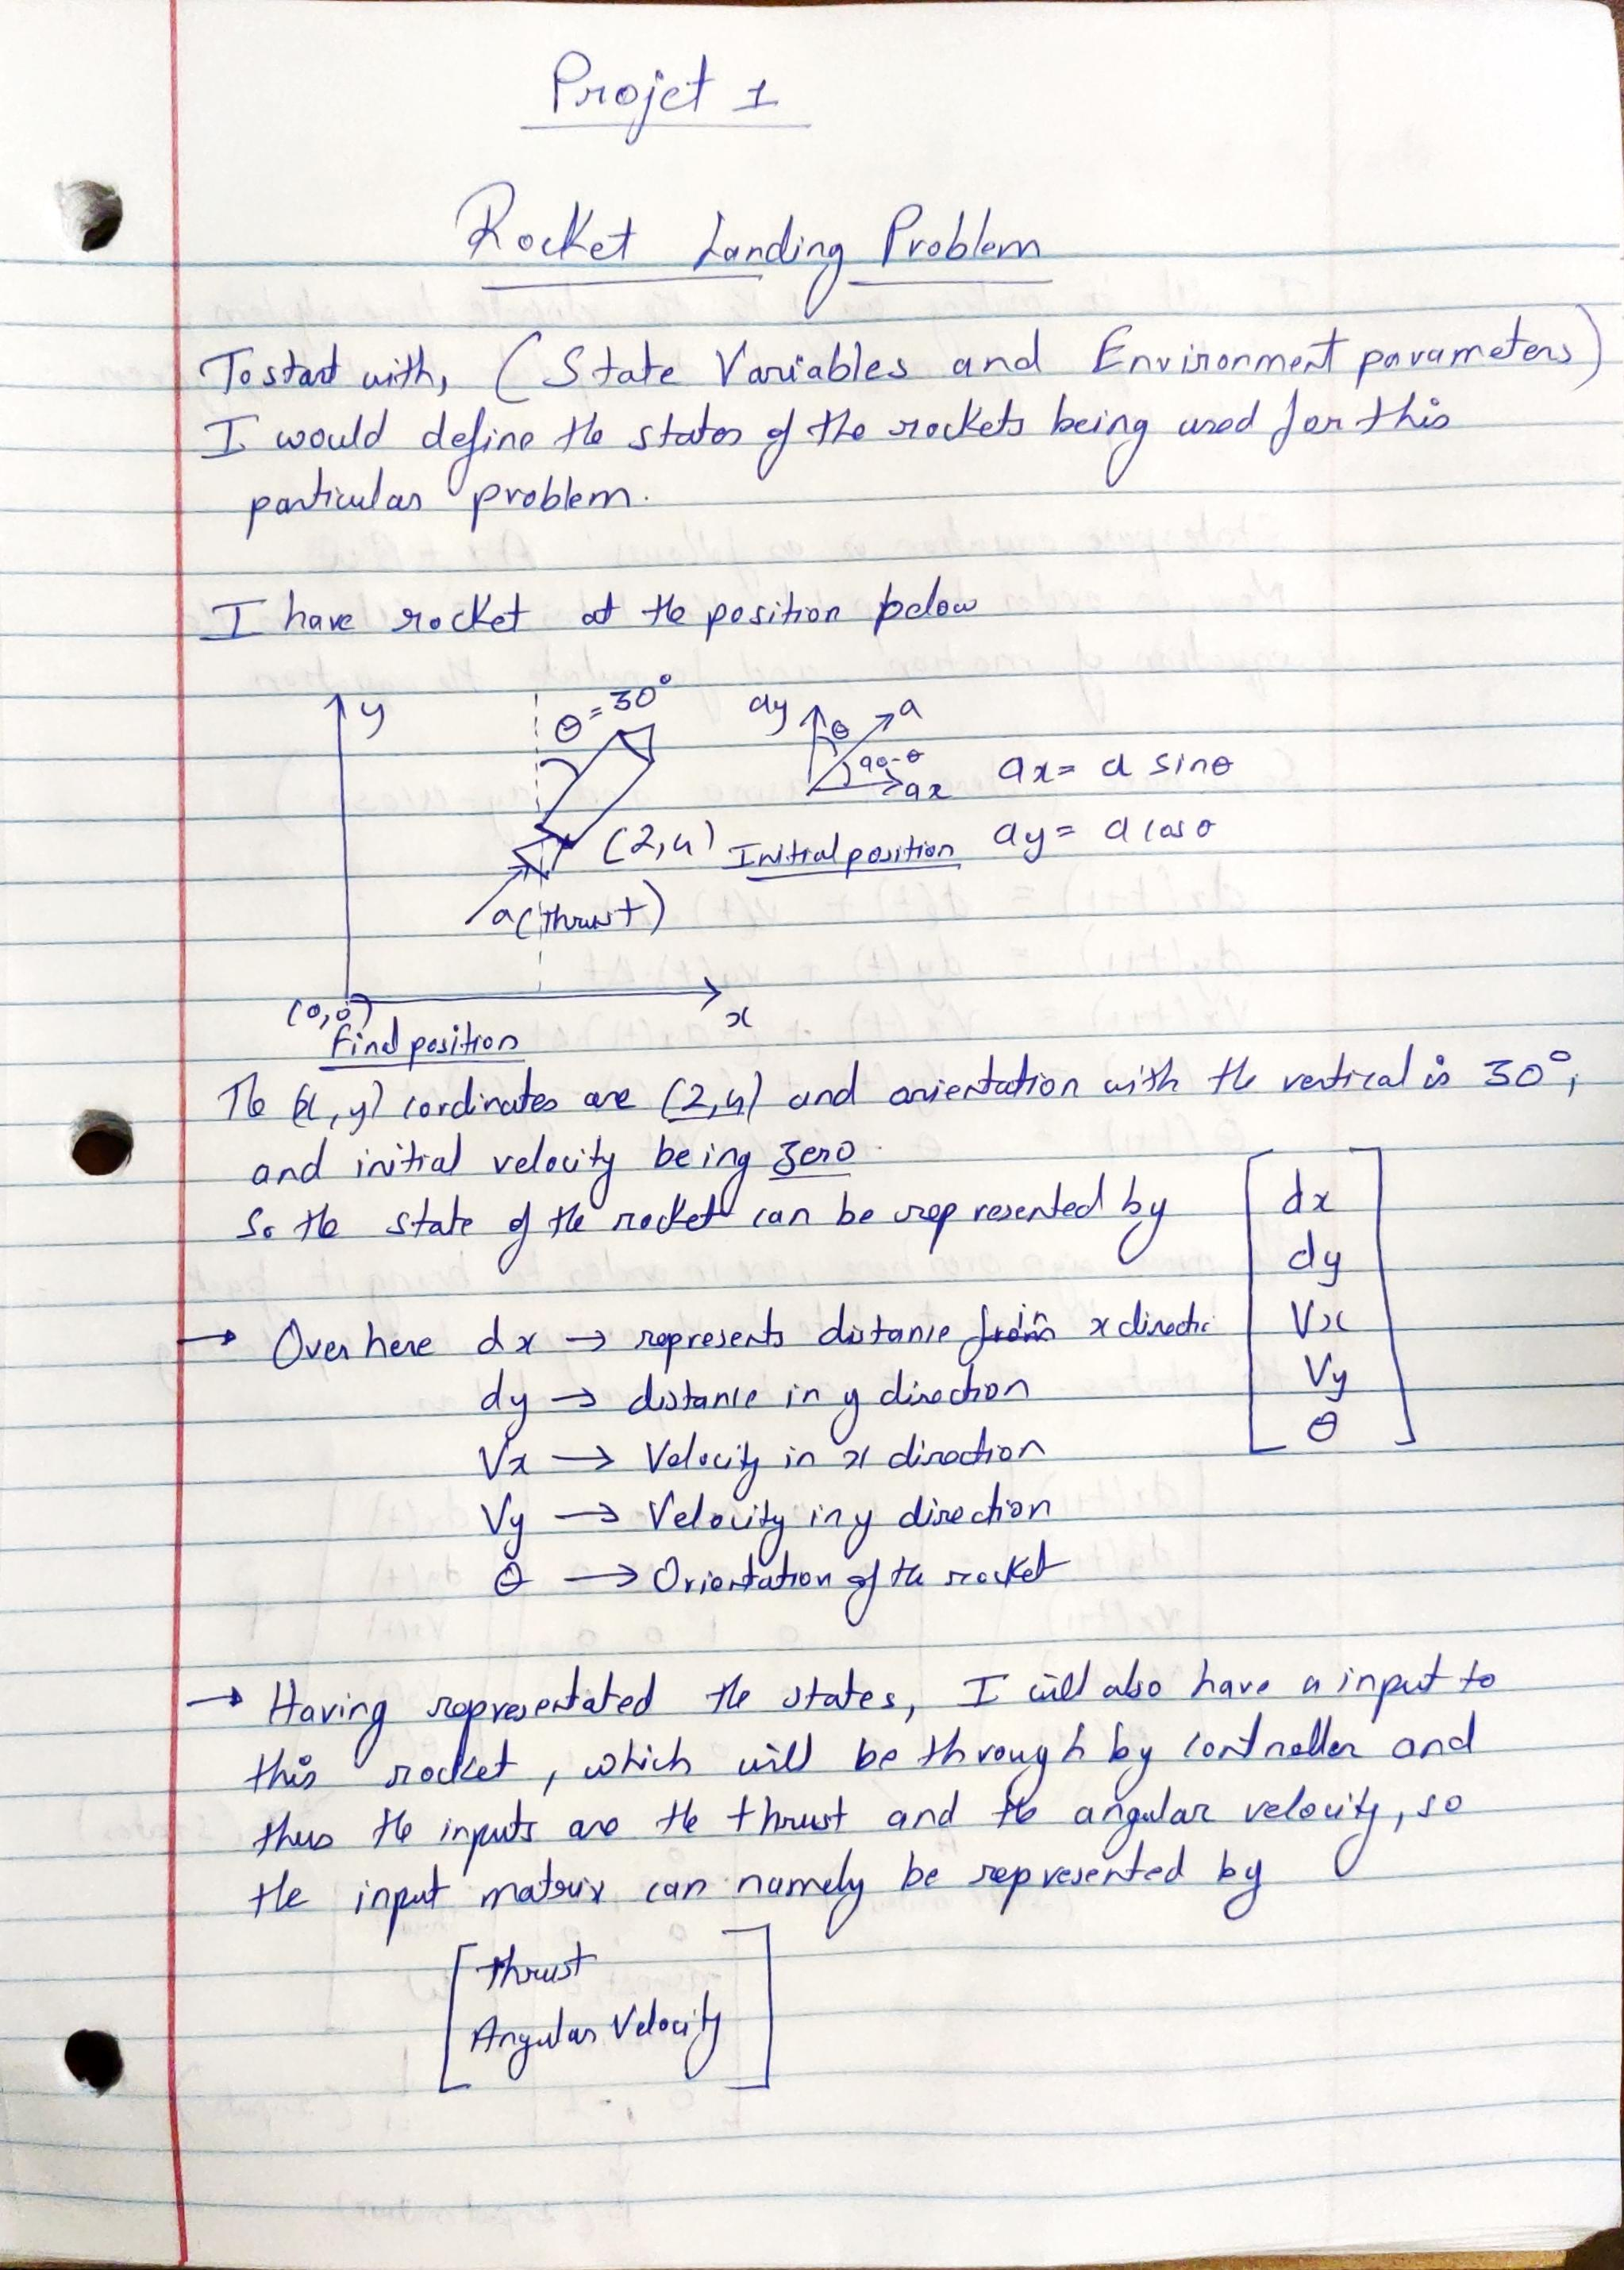

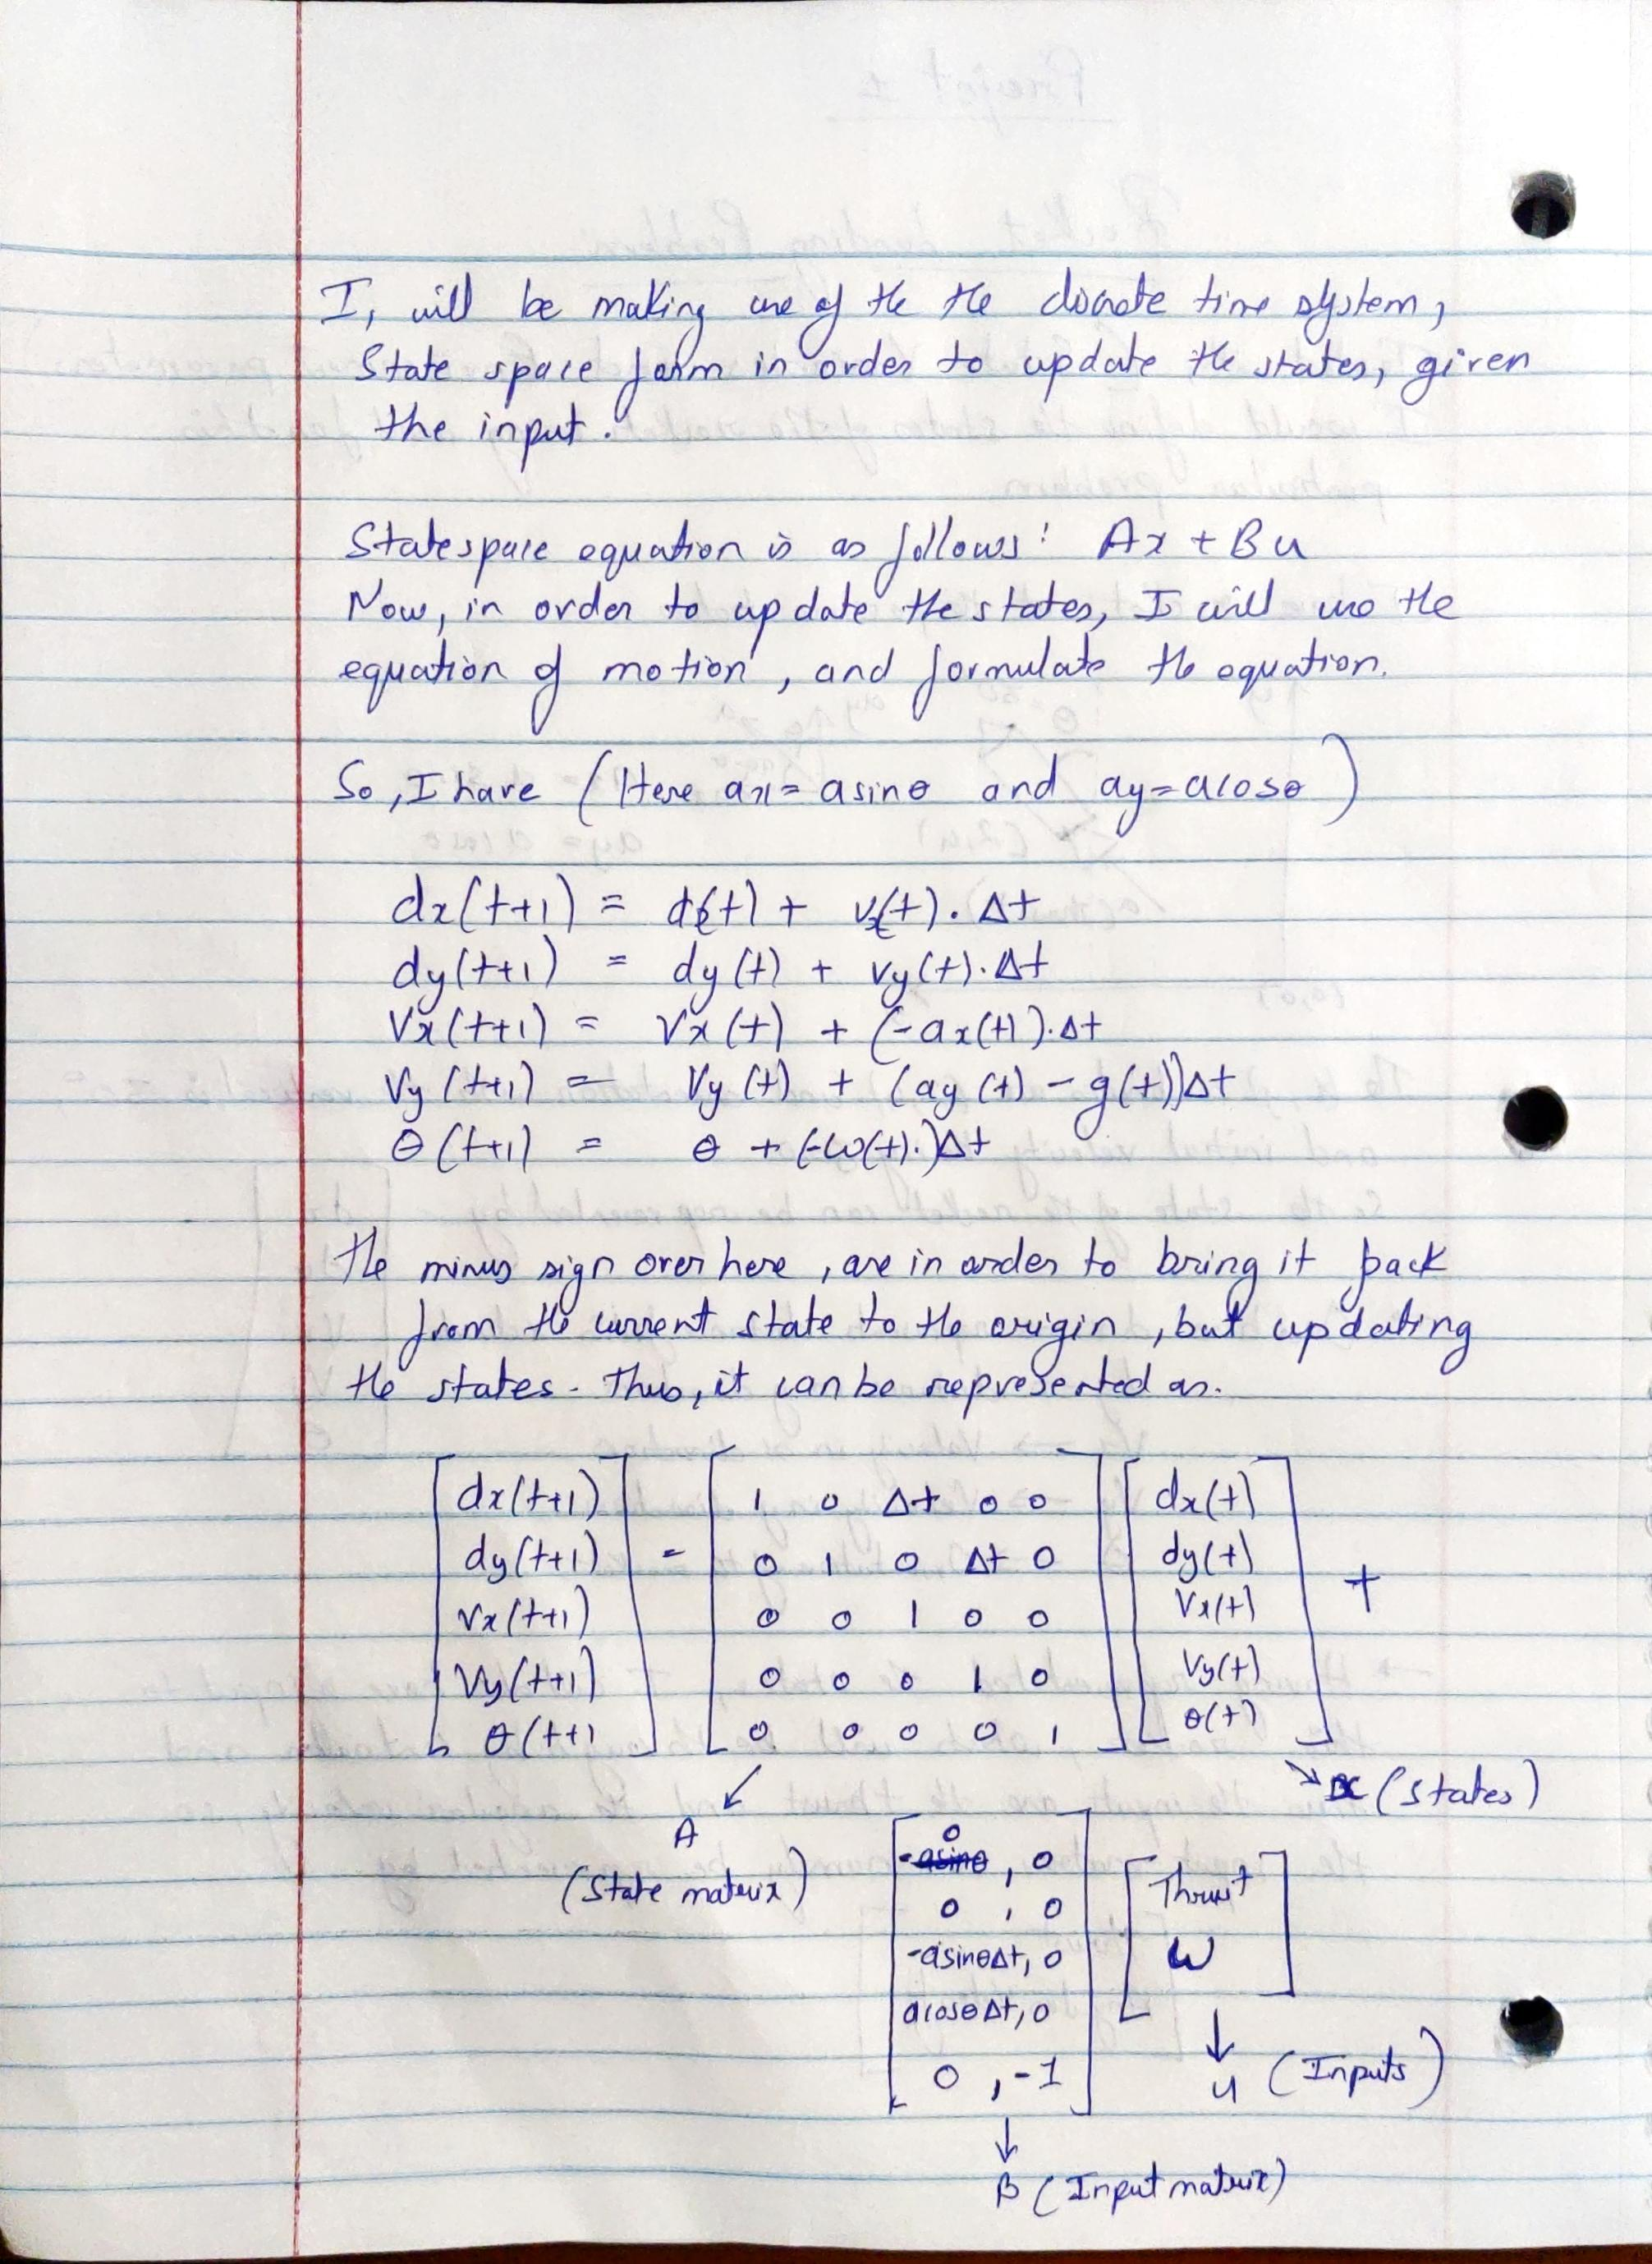

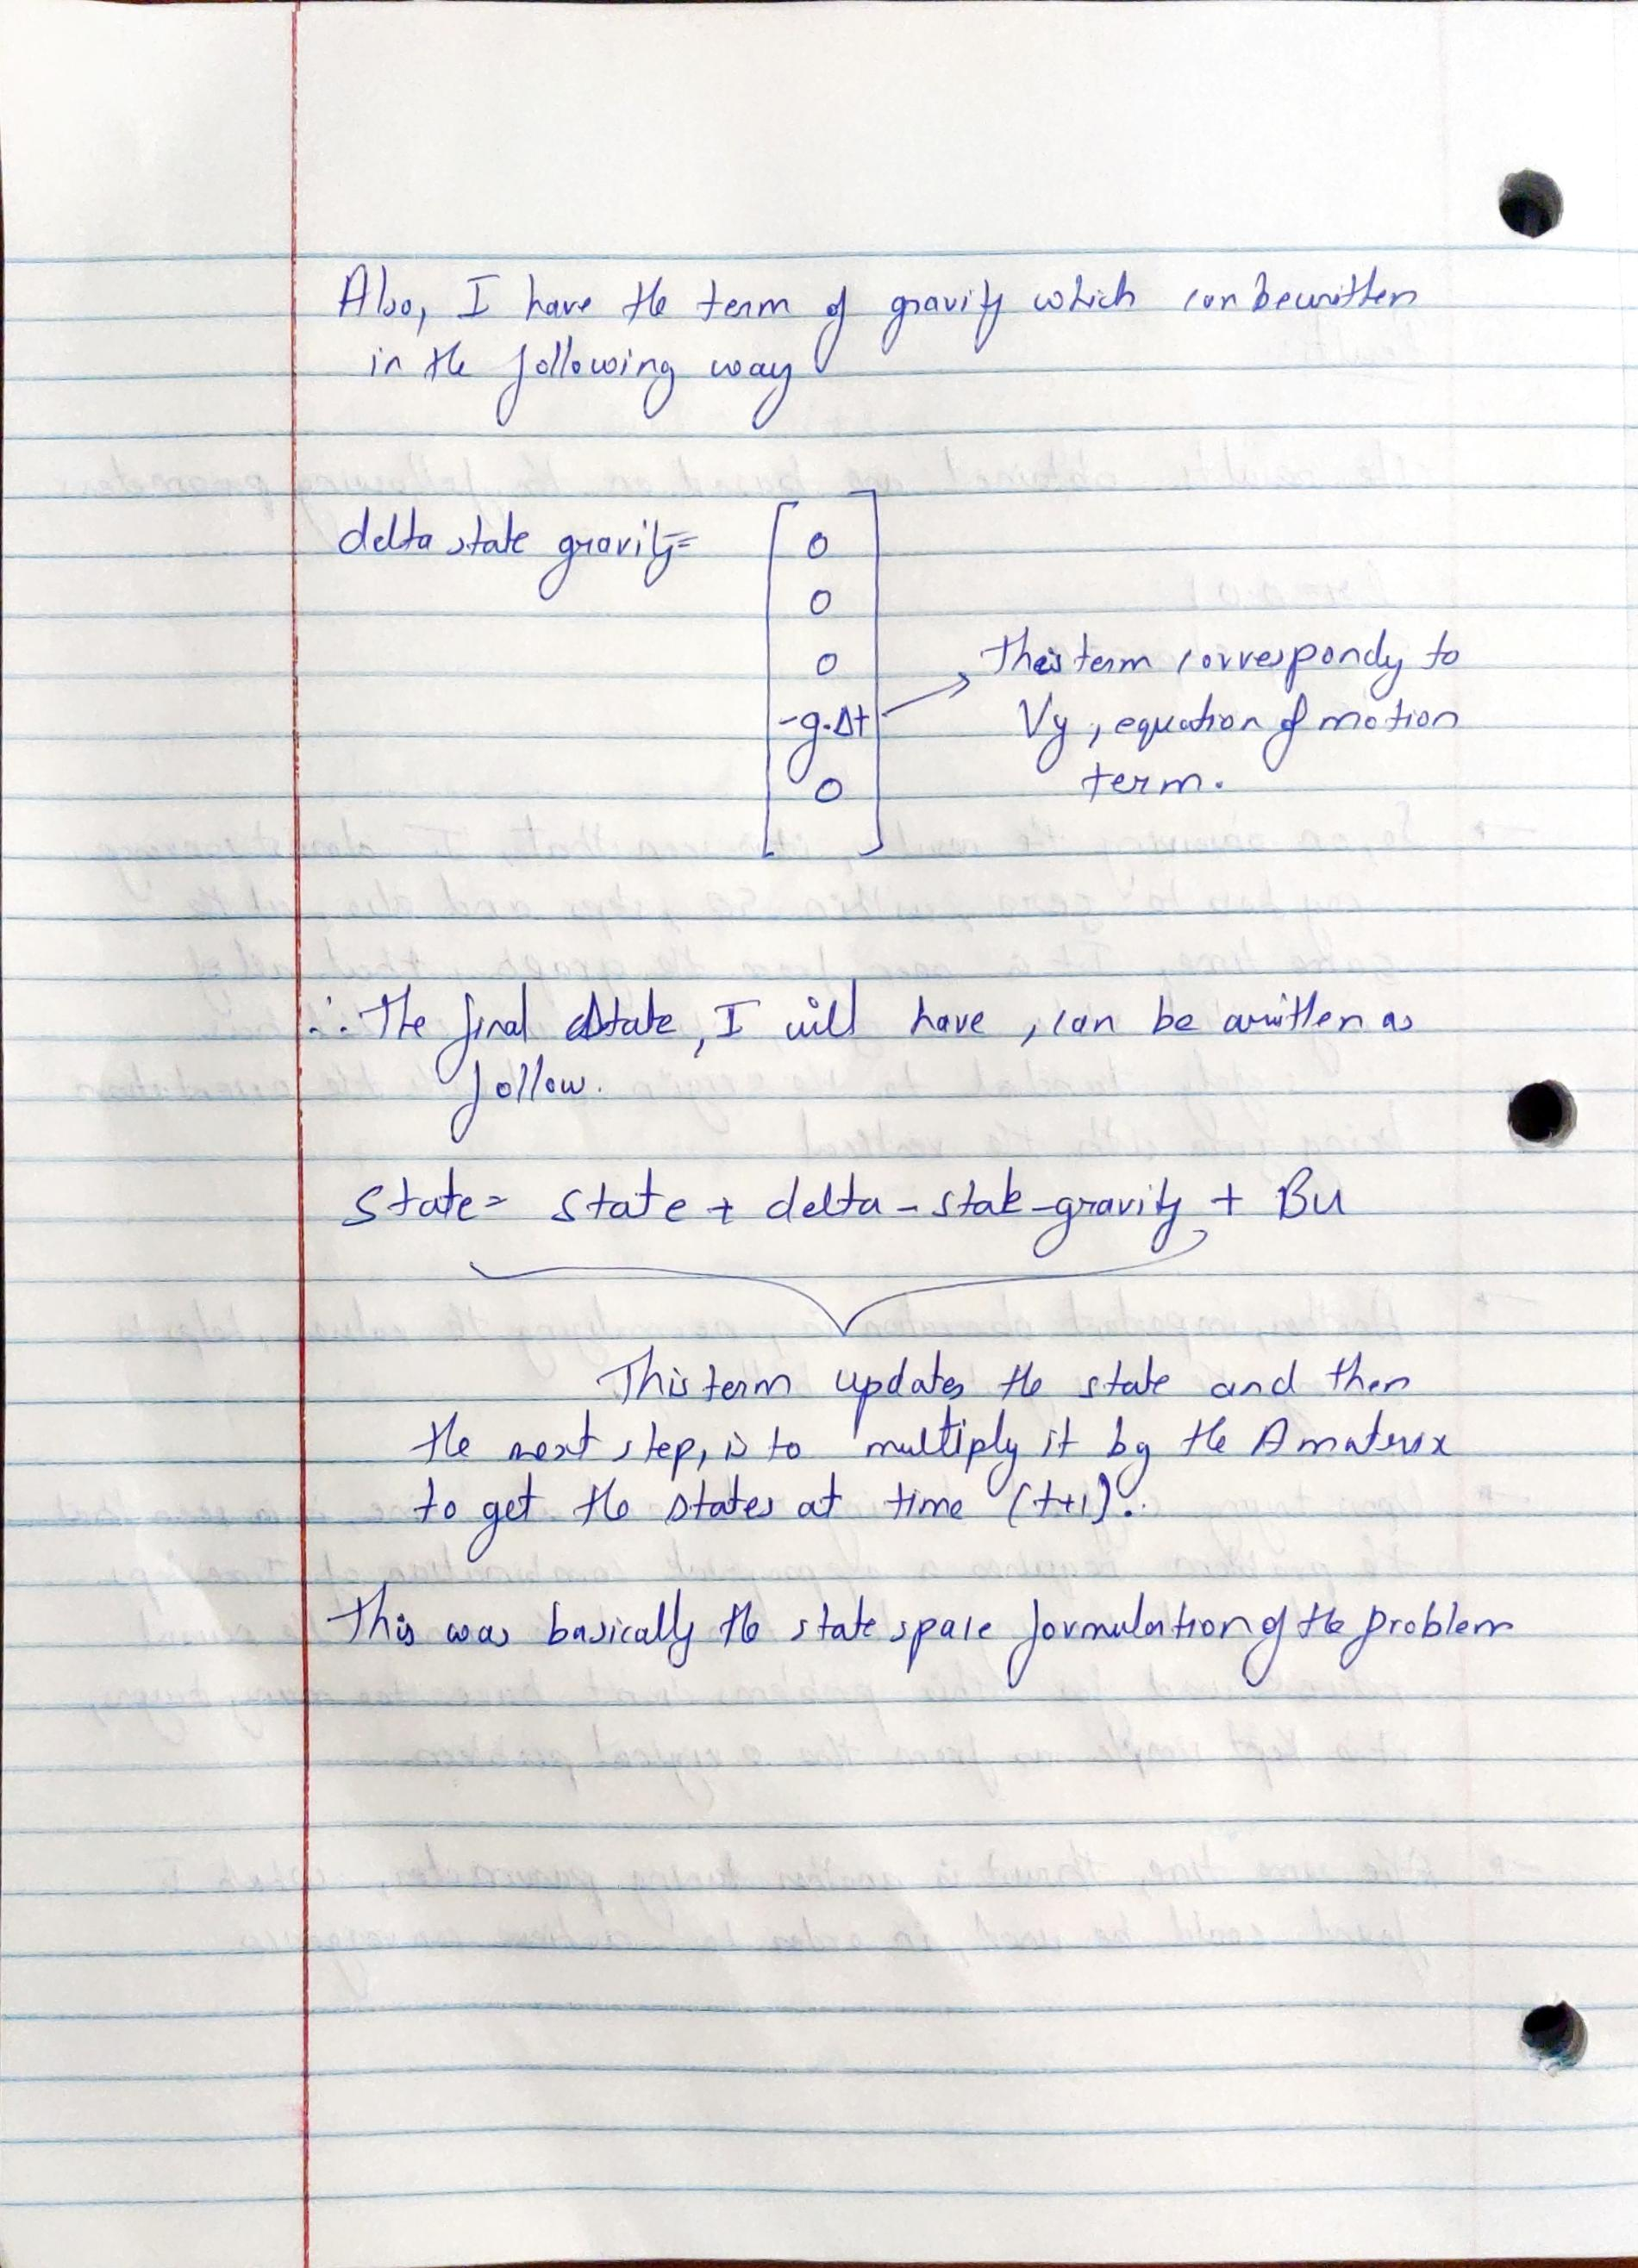

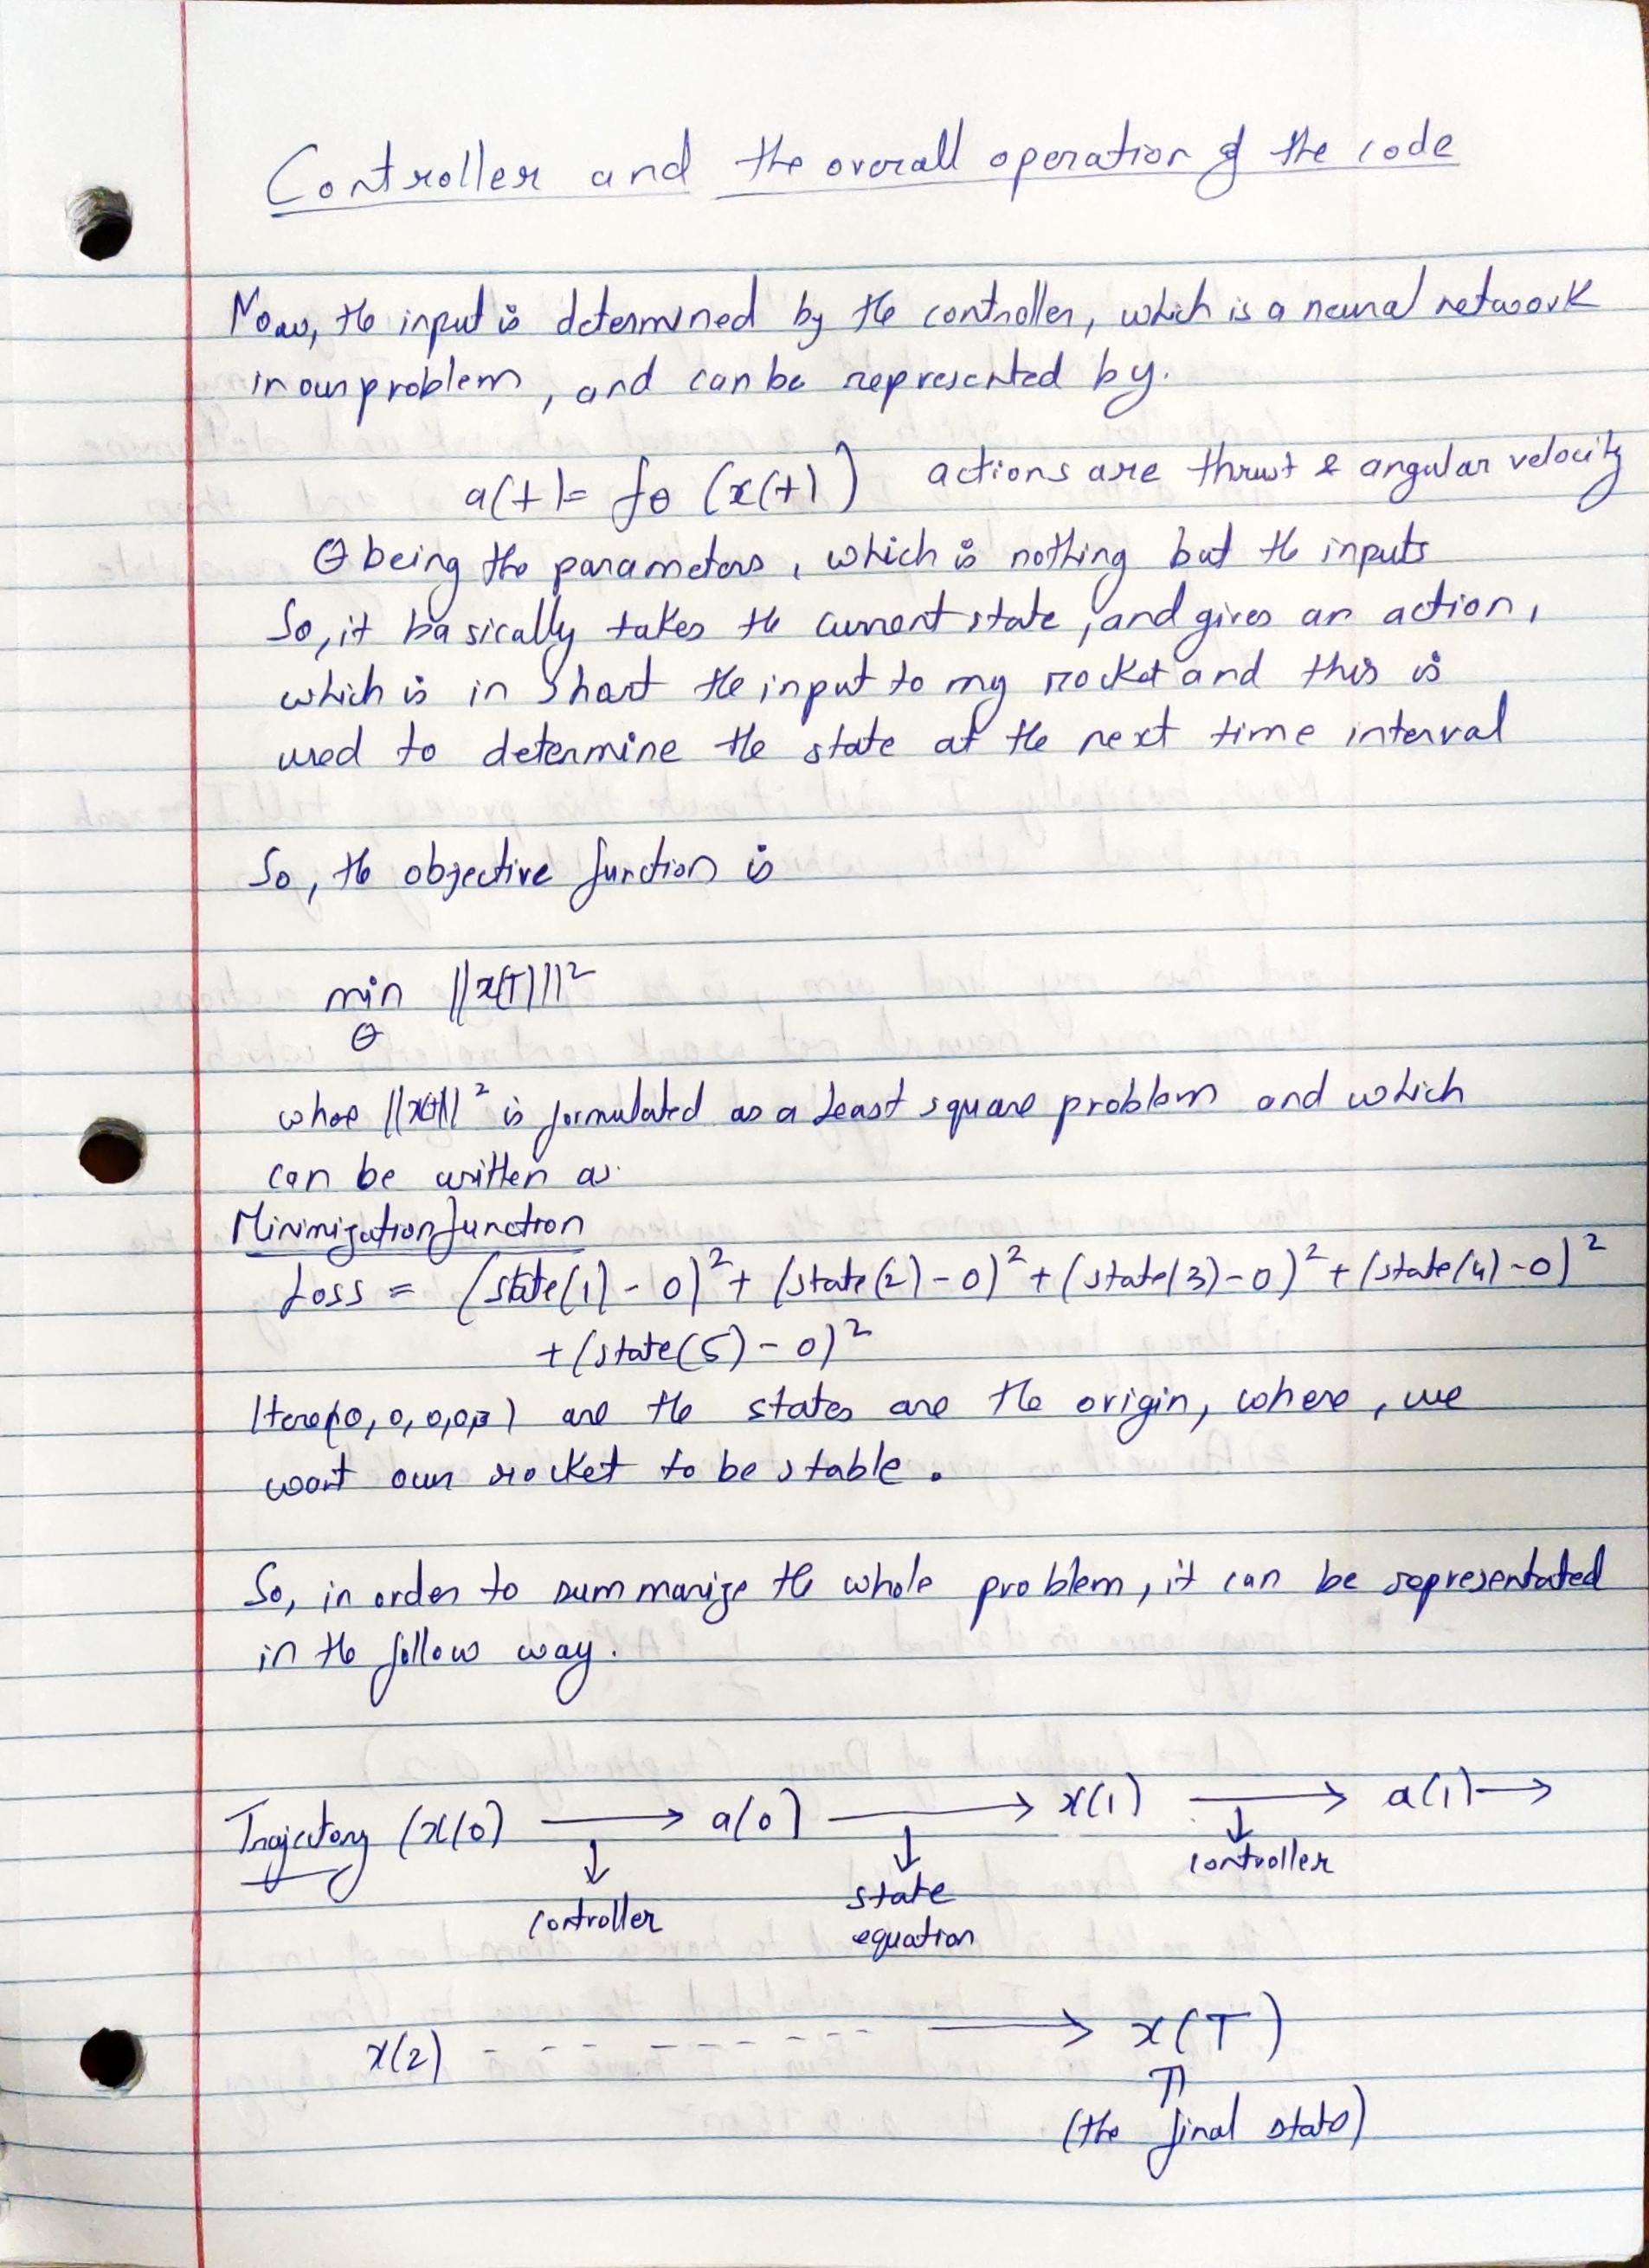

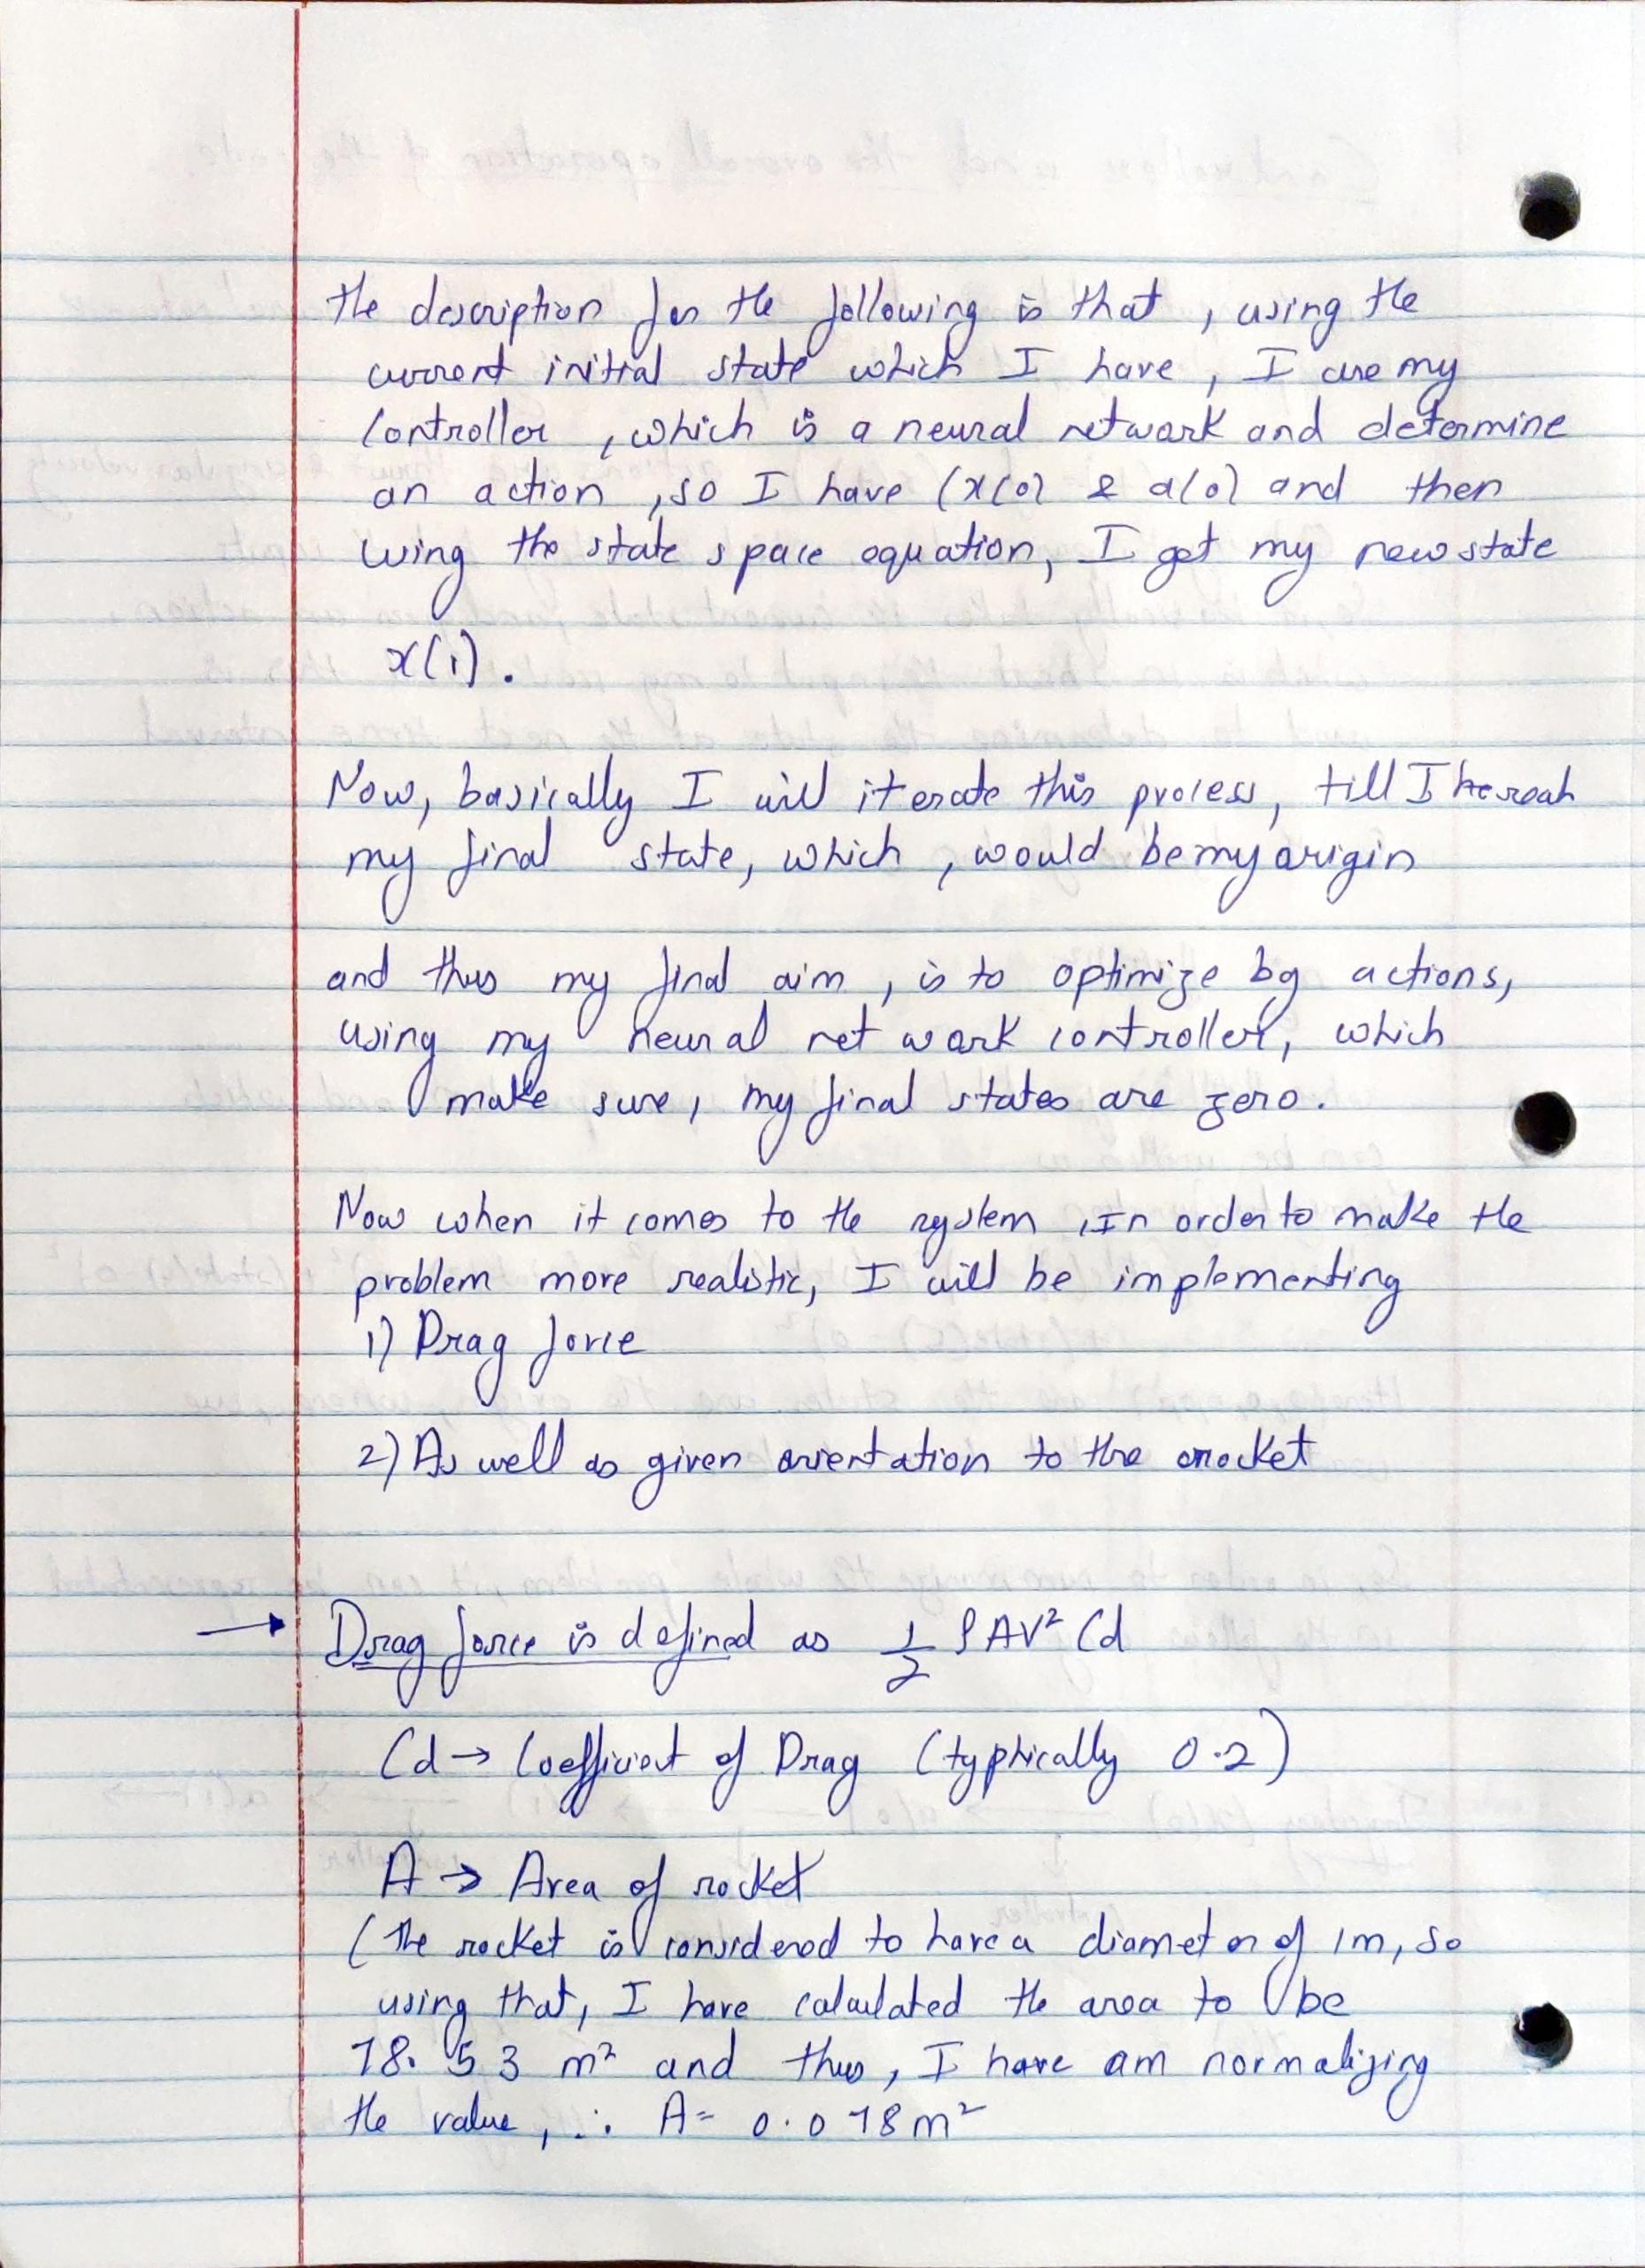

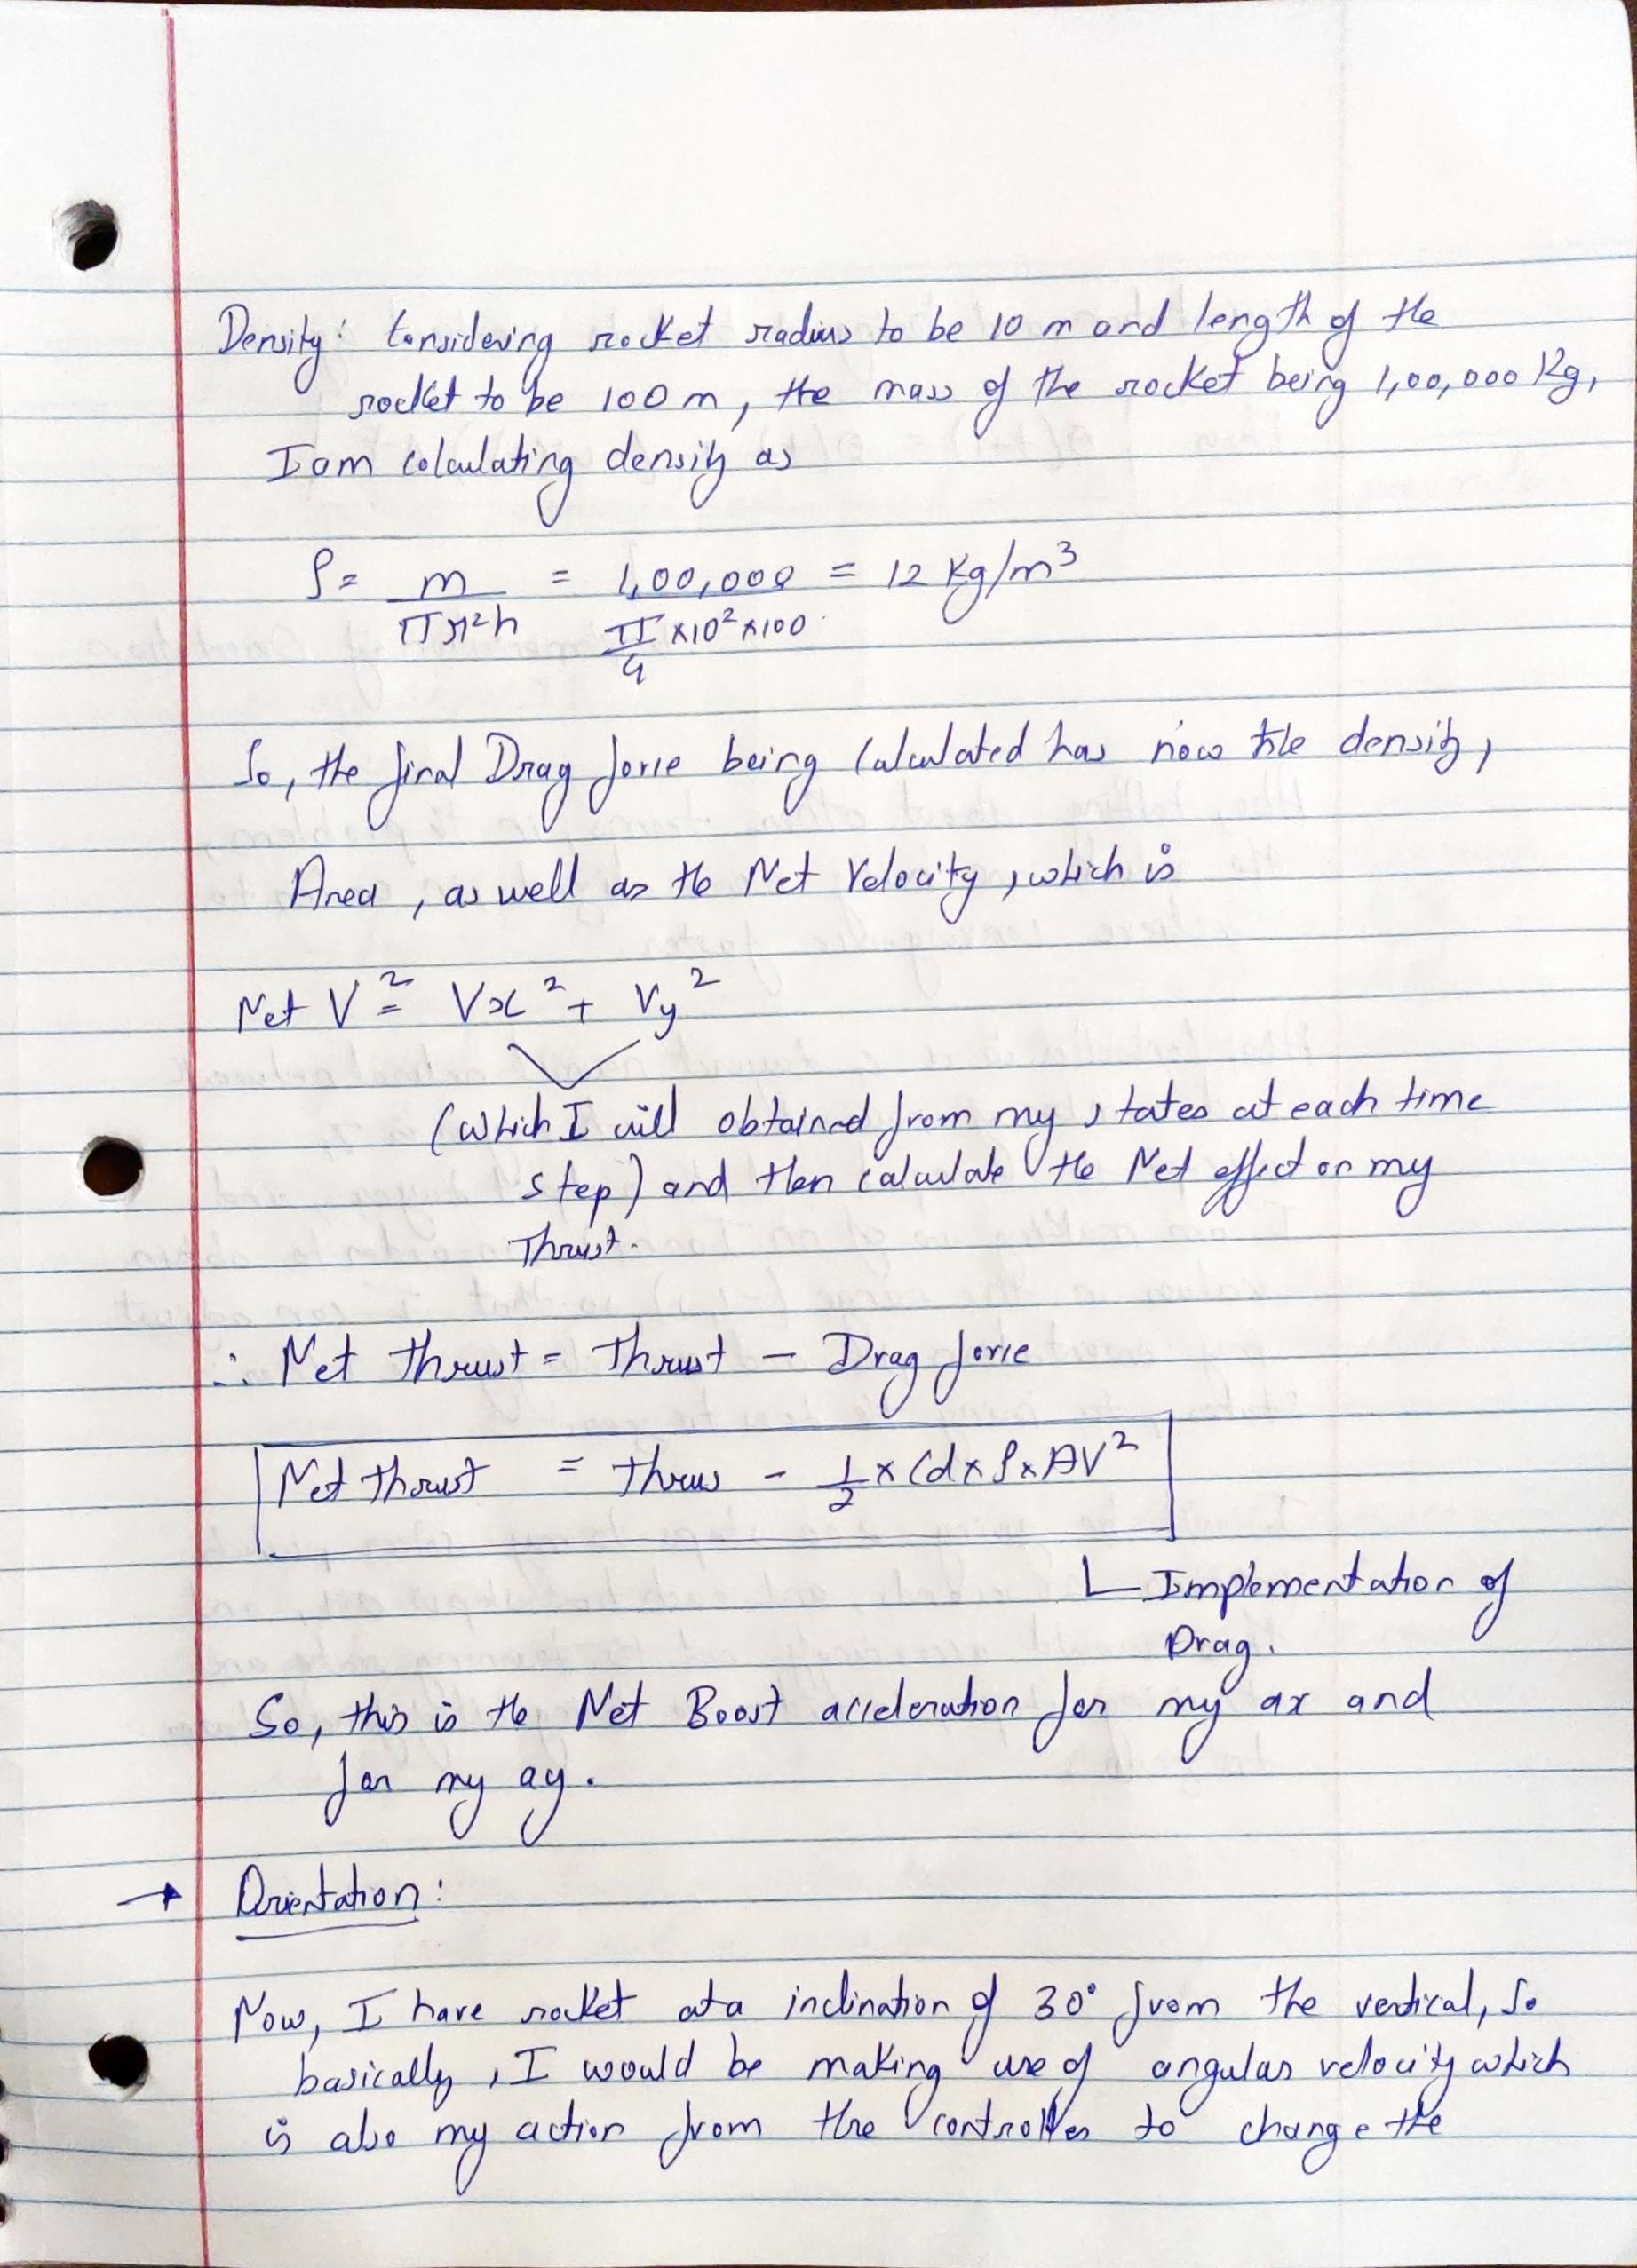

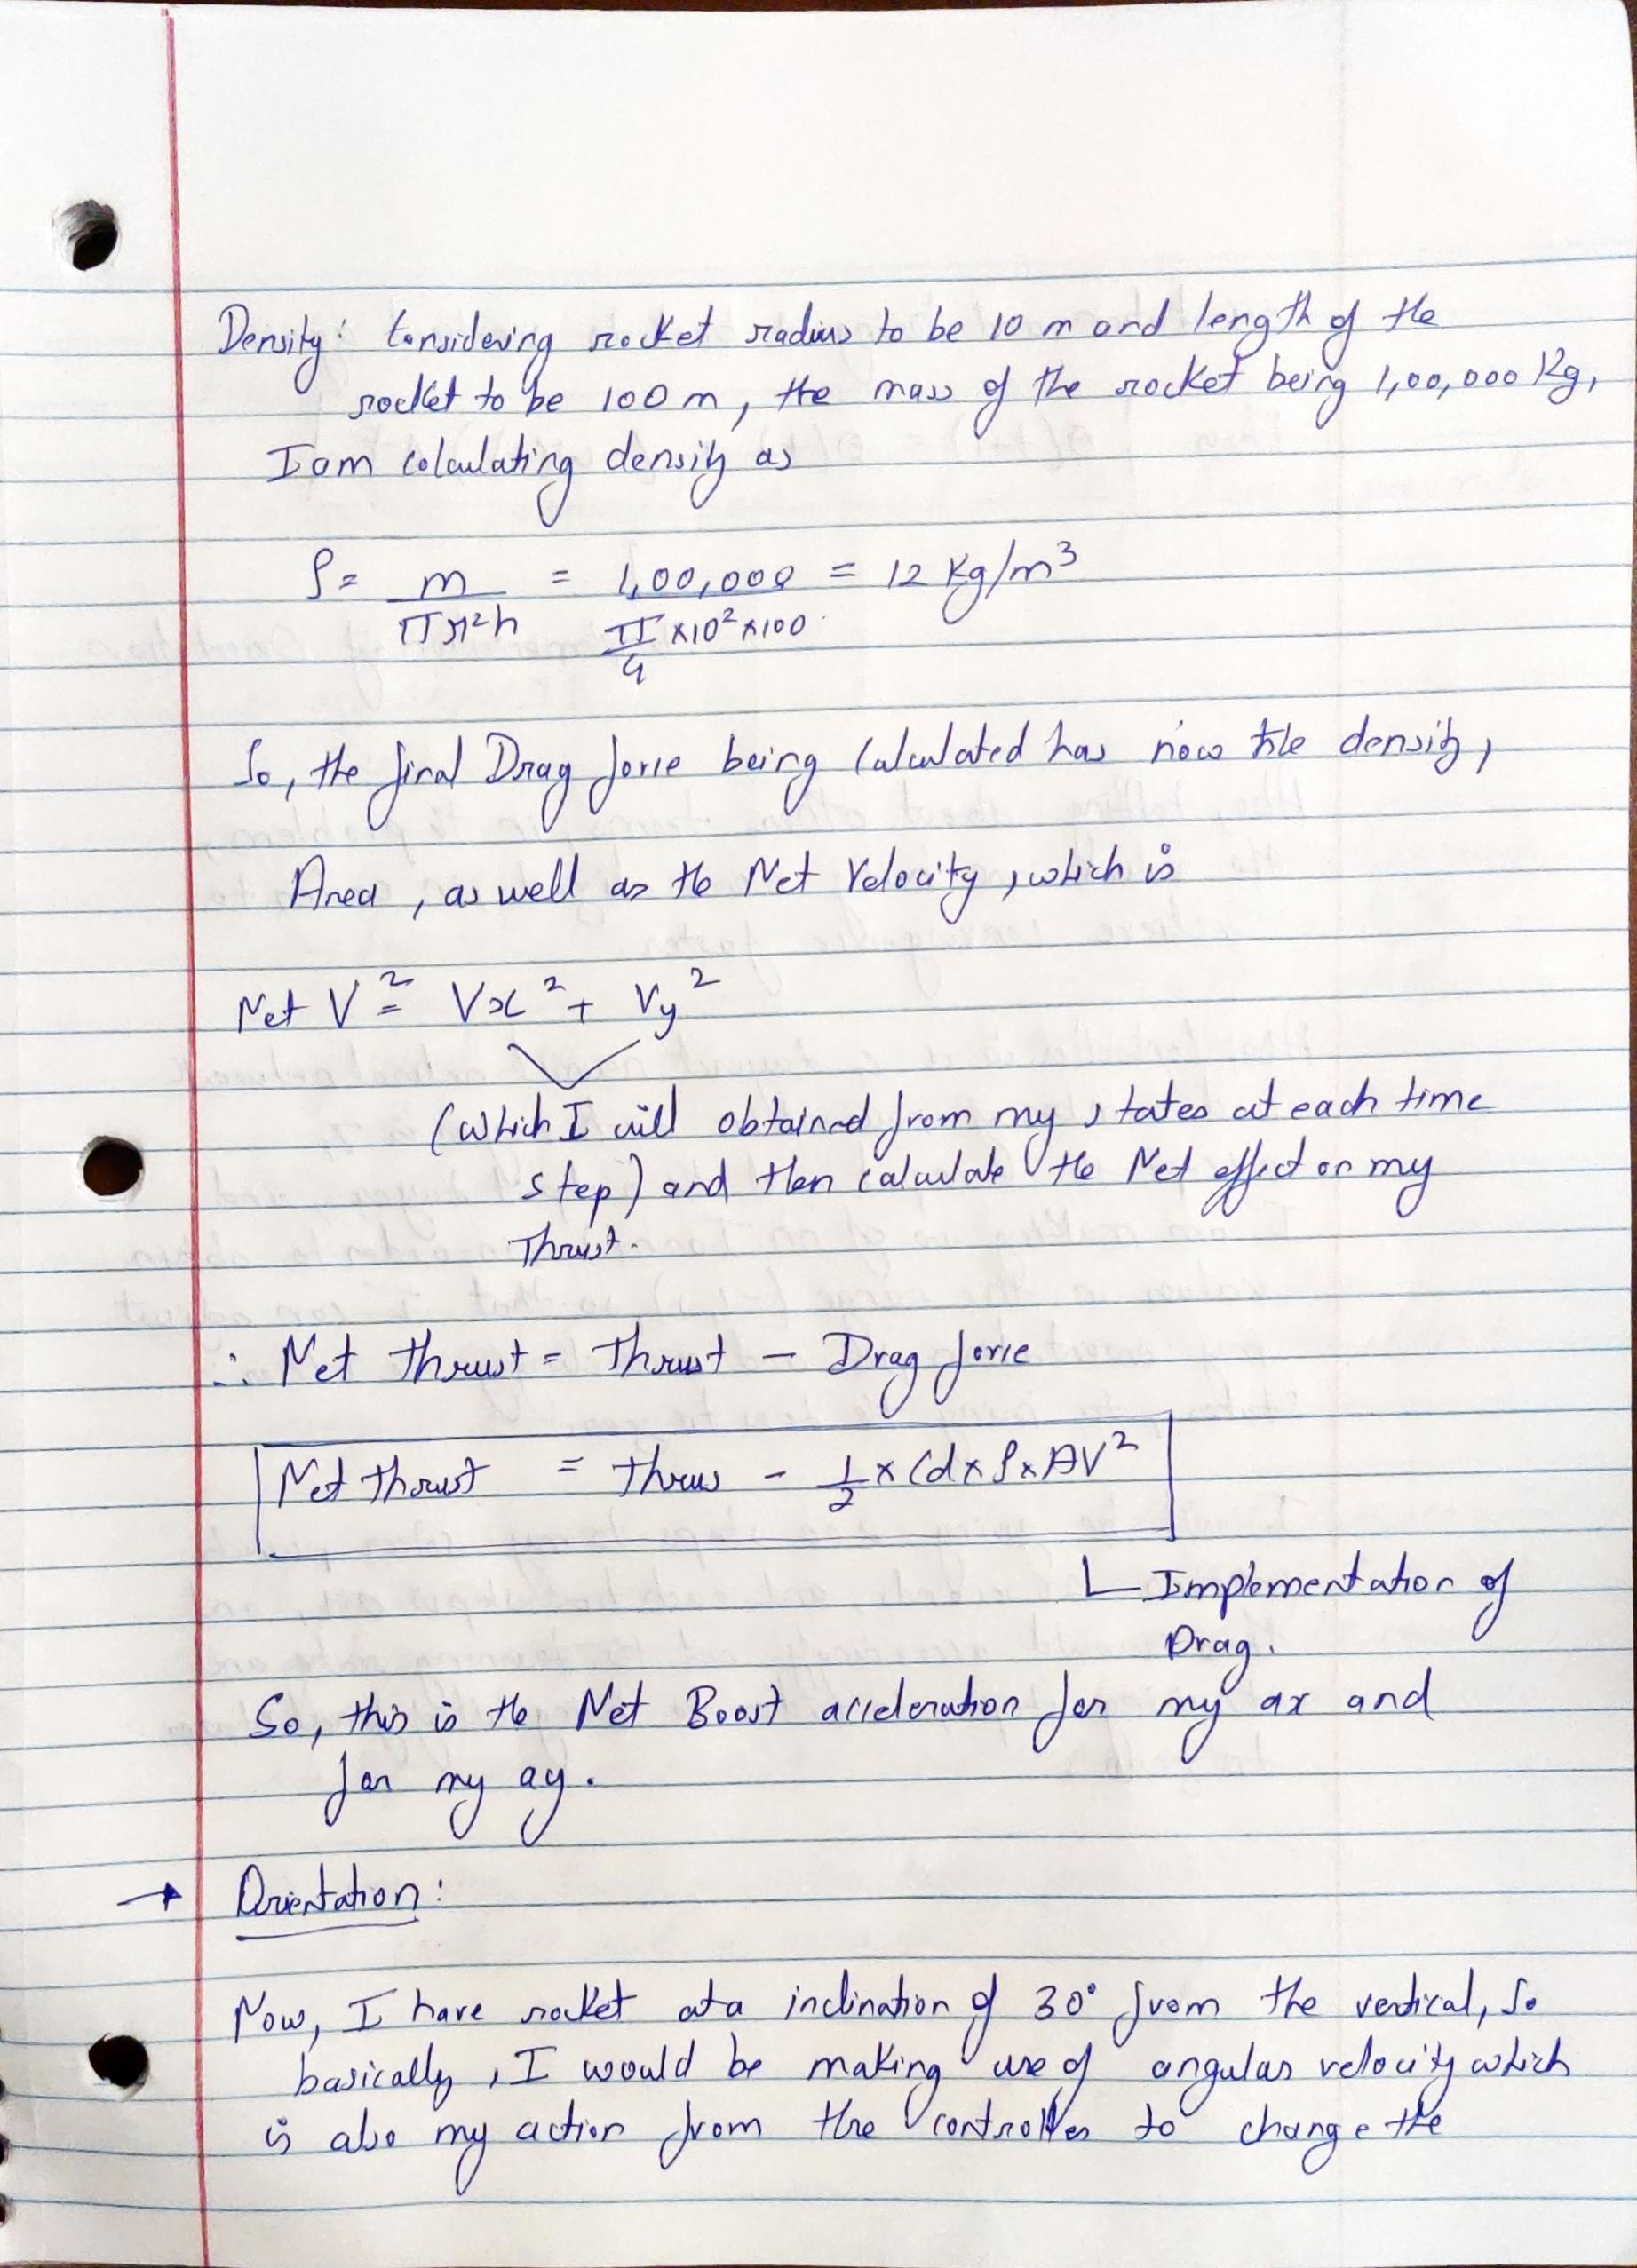

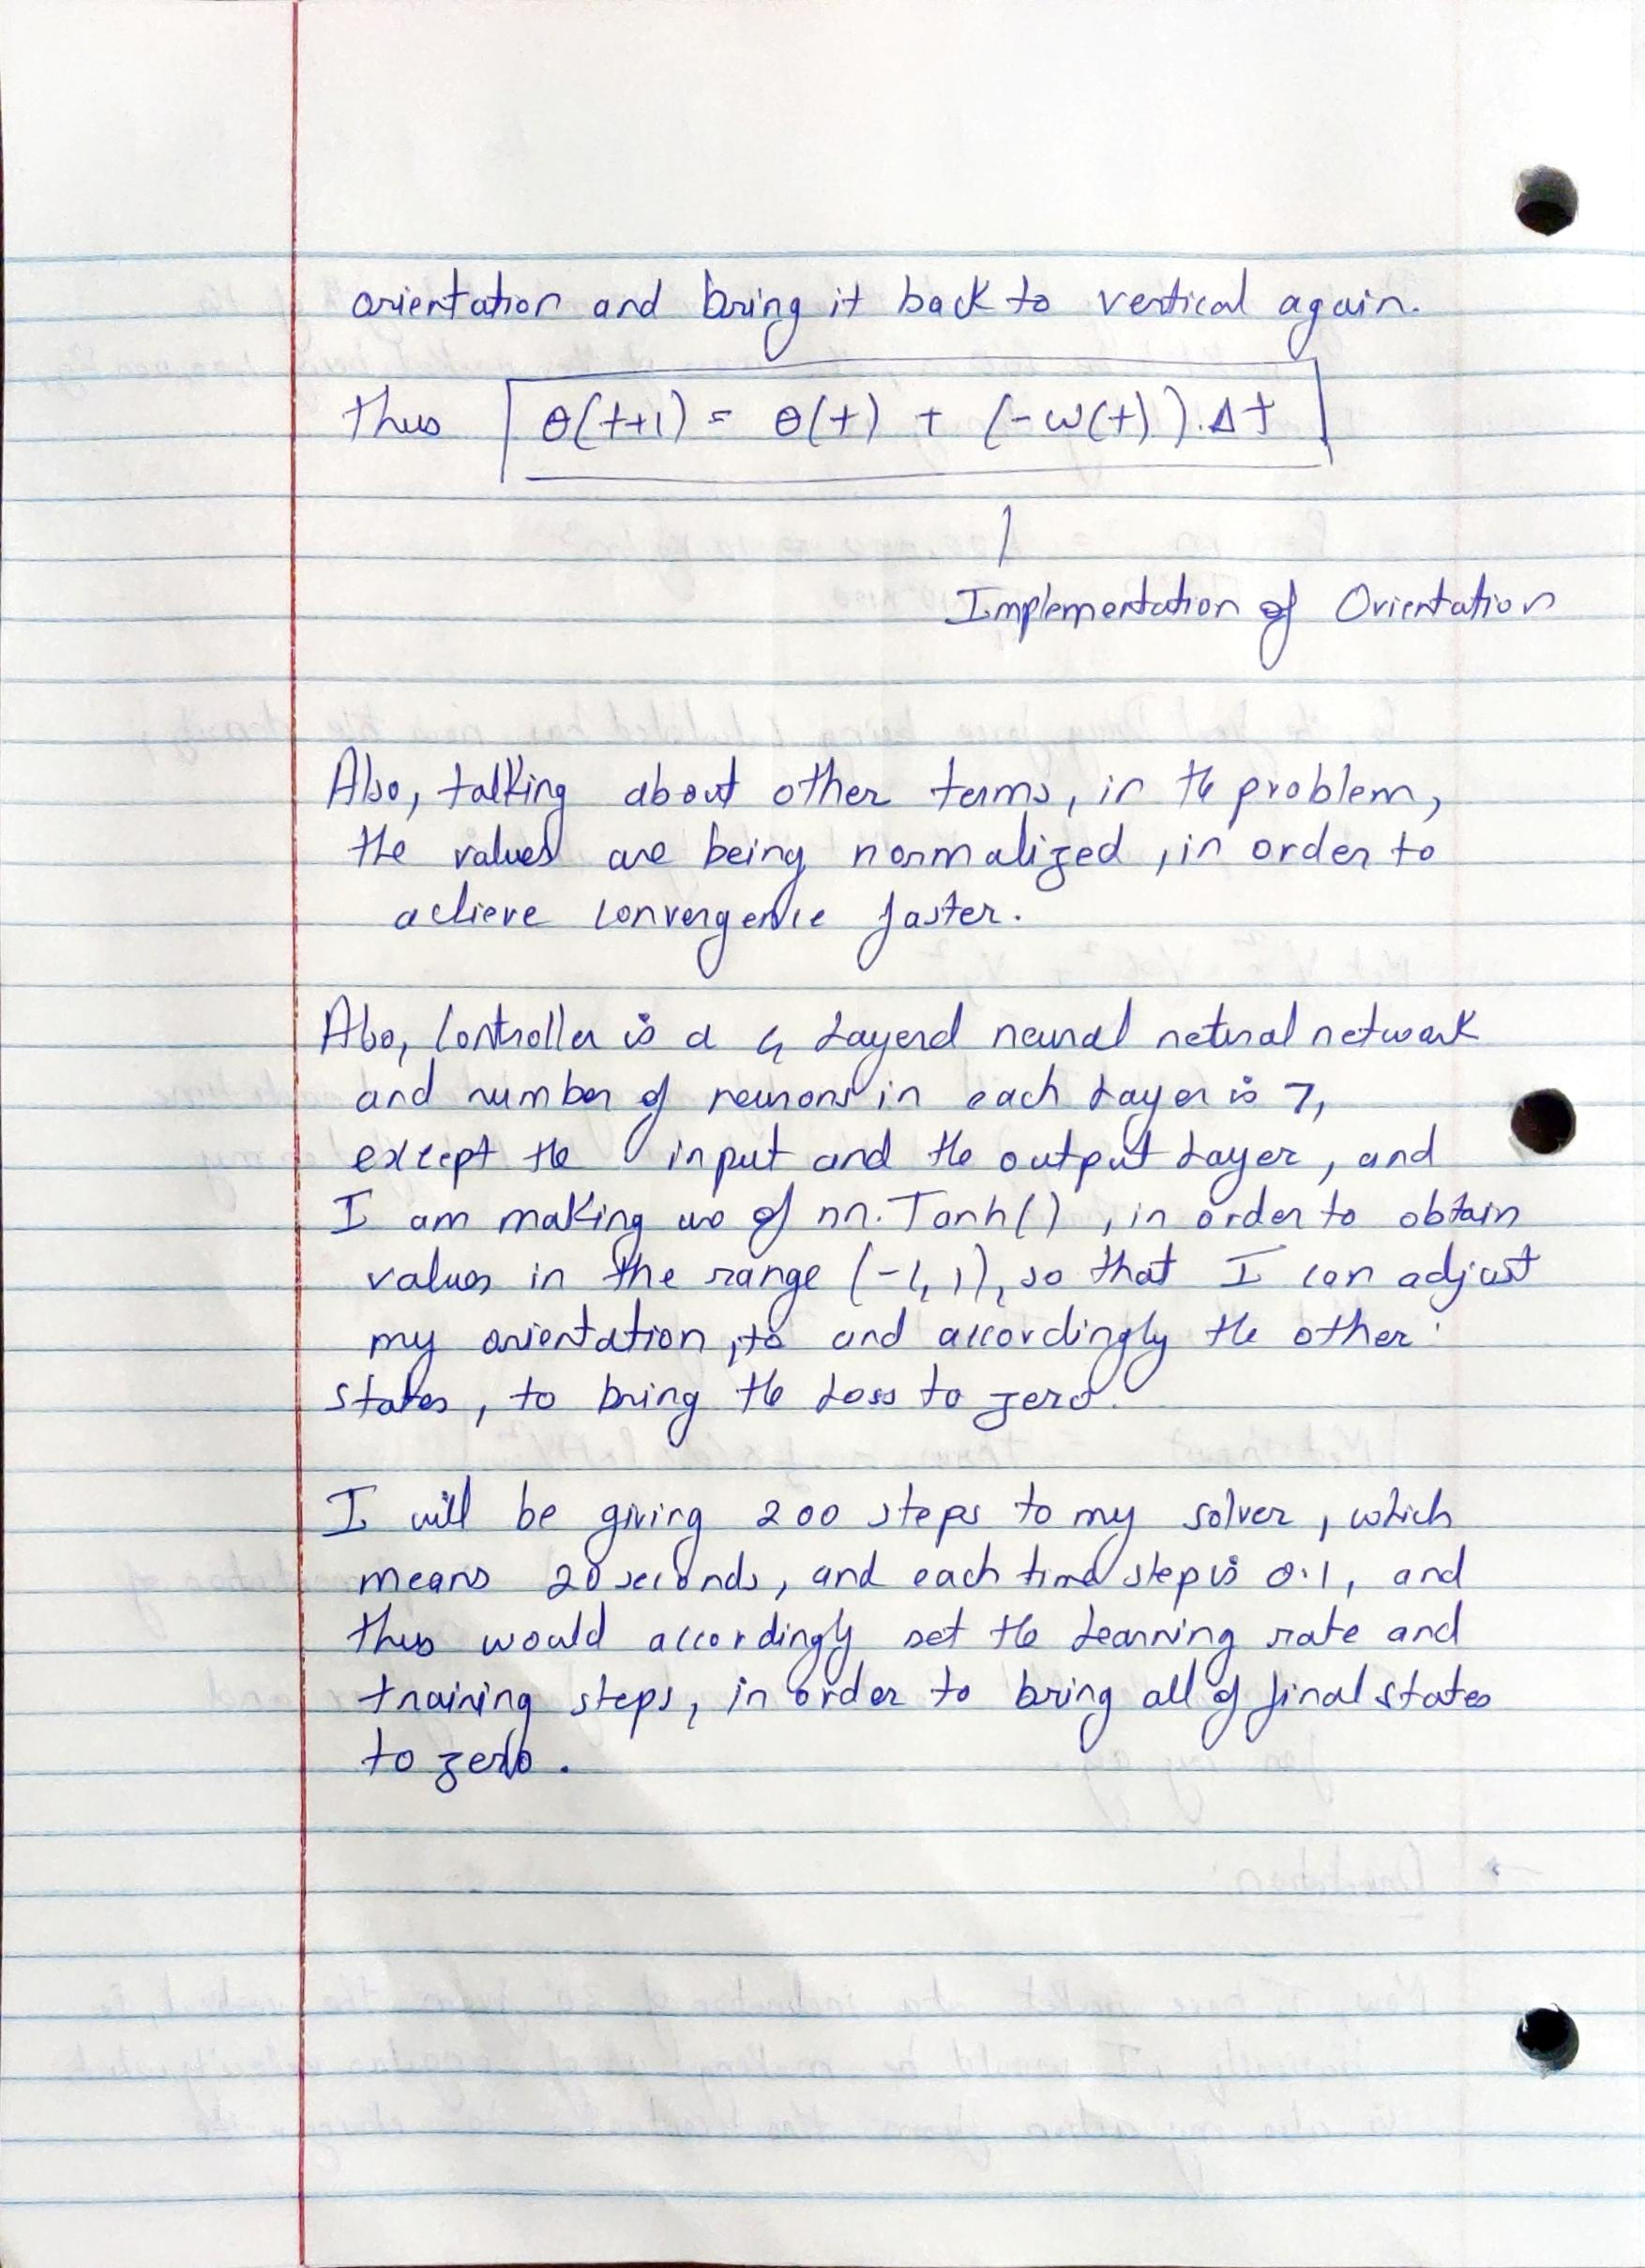

In [ ]:


import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [2]:
# Environment parameters

FRAME_TIME = 0.1               # Time interval
GRAVITY_ACCEL = 0.0098         # Gravity constant in units Km/sec^2  (Normalizing the value)
BOOST_ACCEL = 0.3              # Thrust constant in unit KN (Normalizing the value) 

Cd =0.2                        # Coefficient of Drag of the Rocket
A=0.078                        # Considering the rocket has a radius of 1m, the following is the circular cross sectional Area 
Density= 12                    # Considering the mass of the rocket to be 100000 kg and assuming a height of rocket to be 100m, following is the density of the rocket(in Kg/M^3)




In [3]:

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        Action from the controller:
        
        action[0]: thrust or no thrust
        action[1]: Angular Velocity
        
        States :
        
        state[0] = x      (Distance from origin in x-direction) 
        state[1] = y      (Distance from origin in y-direction)
        state[2] = x_dot  (Velocity in the x-direction) 
        state[3] = y_dot  (Velocity in the y-direction)
        state[4] = theta  (Angular Orientation of the rocket)
        """
        
        # Applying the Component of gravity for the Velocity in the y-direction
        
        delta_state_gravity = t.tensor([0.,0.,0.,-GRAVITY_ACCEL*FRAME_TIME,0.]) 
        
        
        # Defining a state _tensor for updating the values of acceleration in x & y direction (ax & ay)
        
        state_tensor = t.tensor([0.,0.,0.,0.,0.])    
        state_tensor[2] = -t.sin(state[4])
        state_tensor[3] = t.cos(state[4])
        
        
        # Calculating the Net effect of the Drag
        Vy = t.matmul(state,t.tensor([0., 0., 0., 1.,0.]))  # Calculating velocity in x_direction
        Vx = t.matmul(state,t.tensor([0., 0., 1., 0.,0.]))  # Calculating velocity in x_direction
        Net_V= Vy**2 + Vx**2                                # Calculating Net Velocity 
        Drag_Force = 0.5*Cd*Density*A*Net_V                 # Calculating Drag force over here
        NetBOOST_ACCEL = BOOST_ACCEL - Drag_Force           # Deducting the Drag from the Thrust to find the Net Net Acceleration
        
        
        delta_state = NetBOOST_ACCEL*FRAME_TIME*t.mul(state_tensor, action[0])   # Finding the components ax and ay
        
        
        # Updating the Orientation of the rocket by making use of the angular velocity
        delta_state_theta = FRAME_TIME*t.tensor([0.,0.,0.,0.,-1])*action[1]  

        # Updating  velocities Vx & Vy
        state = state + delta_state + delta_state_theta 
        
        # This is the formulation of the State Matrix
        
        step_mat = t.tensor([[1., 0.,FRAME_TIME,0.,0.],
                            [0., 1.,0.,FRAME_TIME,0.],
                            [0.,0.,1.,0.,0.],
                            [0.,0.,0.,1.,0.],
                            [0.,0.,0.,0.,1.]
                            ])
        
        state = t.matmul(step_mat, state.T)           # Multiplying the state matrix by the  states
        return state.T                                # Returing the updated states to the controller for giving out the action

In [4]:
# Defining the Controller to with 7 neurons in each hidden layer

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: Considering 7 neurons in each Hidden Layer
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(), 
            nn.Linear(dim_hidden, dim_output ),
            nn.Tanh()
            )

    def forward(self, state):
        action = self.network(state)
        return action

In [5]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [2.,4.,0.,0.,math.pi/6]                                               # Giving the following initial state to the rocket
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2 + state[4]**2   # The objective function to be minimized

In [6]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        data_2 = np.array([self.simulation.action_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        
        Thrust = data_2[:,0]  # Thrust of the Rocket
        omega = data_2[:,1]   # Angular Velocity of the Rocket
        
        x = data[:, 0]        # X position
        y = data[:, 1]        # Y position
        vx = data[:, 2]       # Vx Velocity
        vy = data[:, 3]       # Vy Velocity
        theta = data[:,4]     # Angular Orientation of the Rocket
        
        Time = np.linspace(1,200,200)
        
        
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        
        ax[0].plot(x,y,c='k',label="position")
        ax[0].set_xlabel('Time Steps ')
        ax[0].set_ylabel('Position of the Rocket')
        ax[0].set(title='Displacement plot')
        ax[0].legend()
        
        ax[1].plot(Time,vx,c="r",label="x velocity")
        ax[1].plot(Time,vy,c="b",label="y velocity")
        ax[1].set_xlabel('Time Steps')
        ax[1].set_ylabel(' Velocity in x & y direction ')
        ax[1].set(title='Velocity Plot')
        ax[1].legend()
        
        ax[2].plot(Time, theta, c="g" ,label='theta')
        ax[2].set_xlabel('Time Steps')
        ax[2].set_ylabel('Angle')
        ax[2].set(title='Orientation')
        ax[2].legend()
        

           
        fig.tight_layout()
        plt.show()
        

<ipython-input-3-1085229cb7ea>:56: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2985.)
  state = t.matmul(step_mat, state.T)           # Multiplying the state matrix by the updated states


[1] loss: 14.946


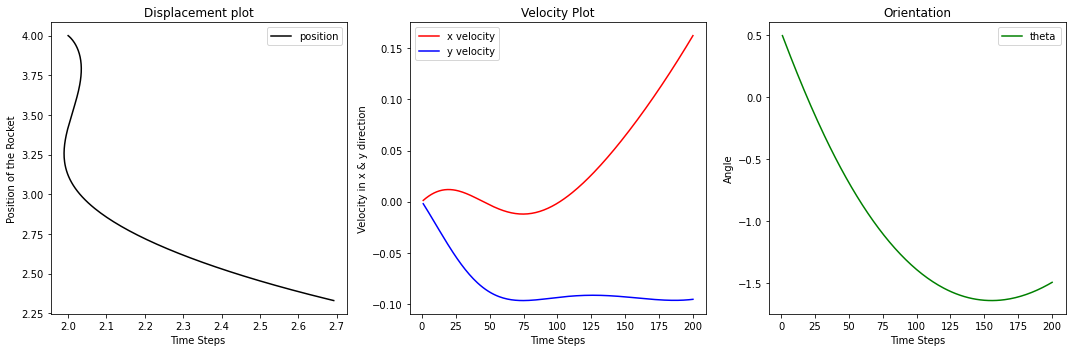

[2] loss: 6.435


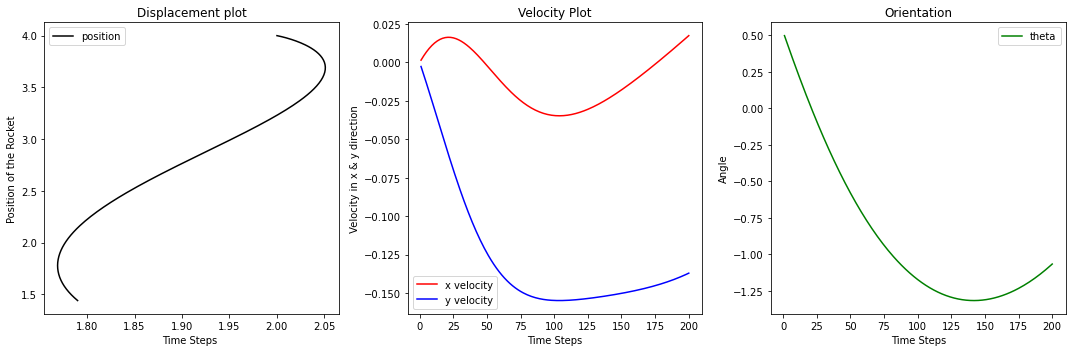

[3] loss: 3.865


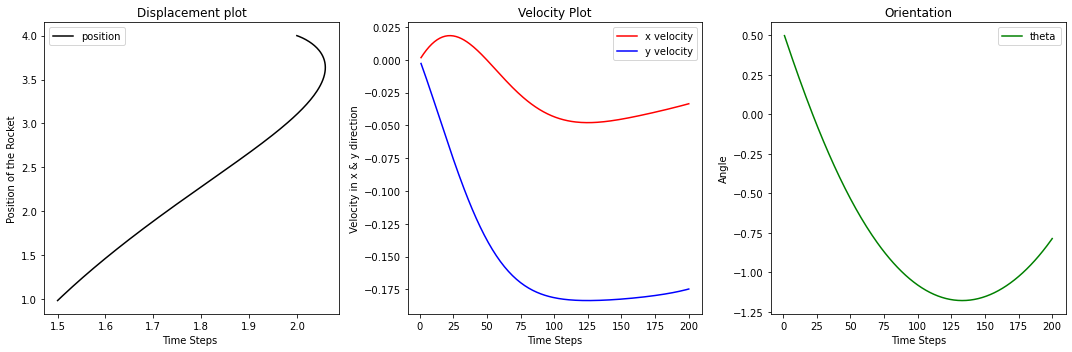

[4] loss: 2.684


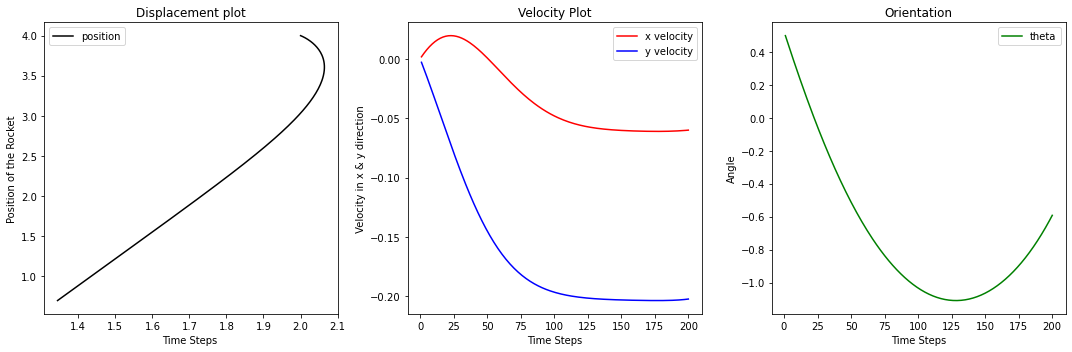

[5] loss: 2.001


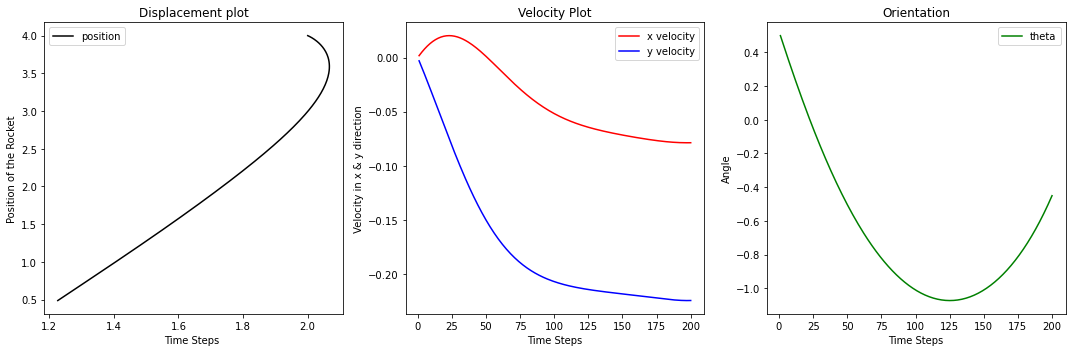

[6] loss: 1.530


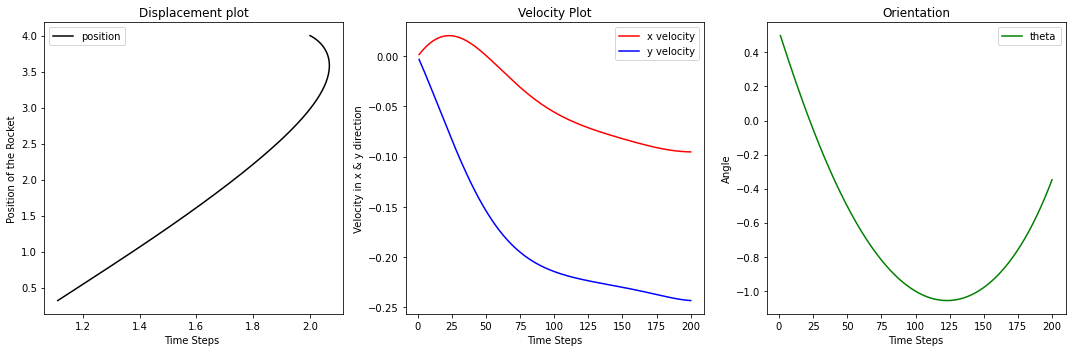

[7] loss: 1.133


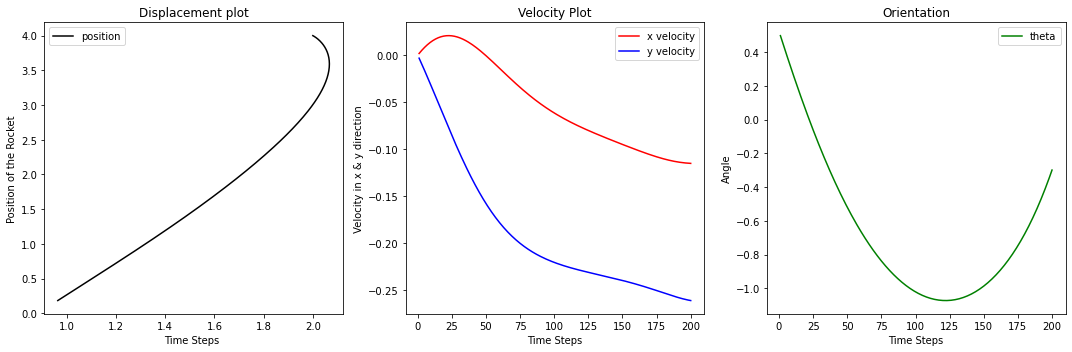

[8] loss: 0.843


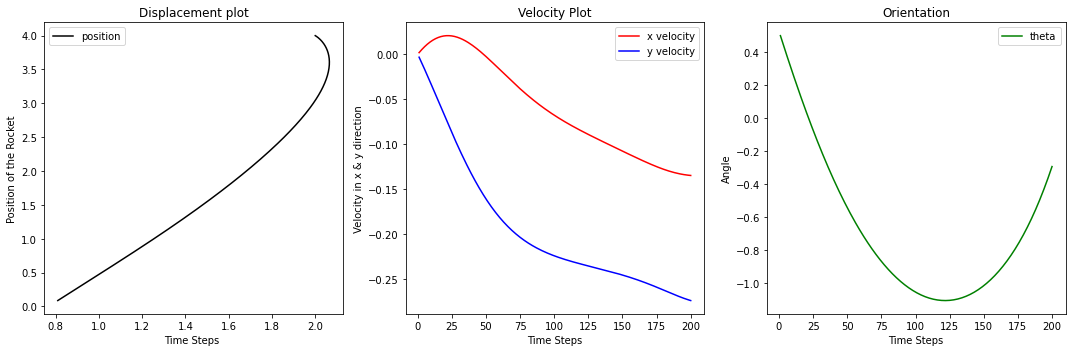

[9] loss: 0.655


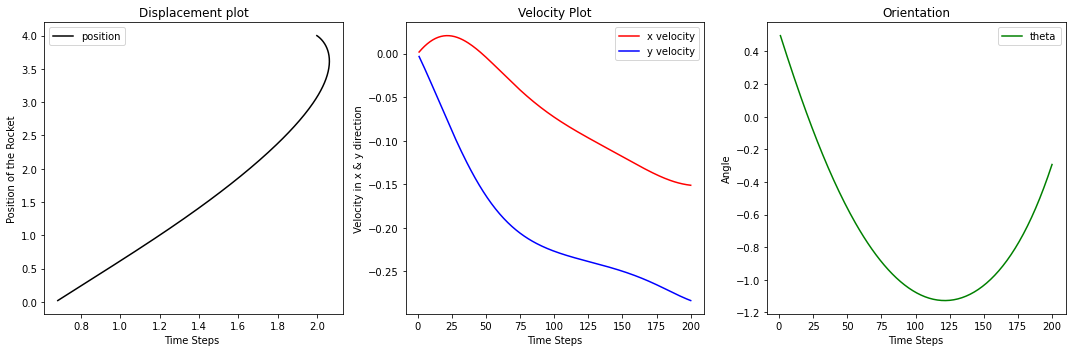

[10] loss: 0.533


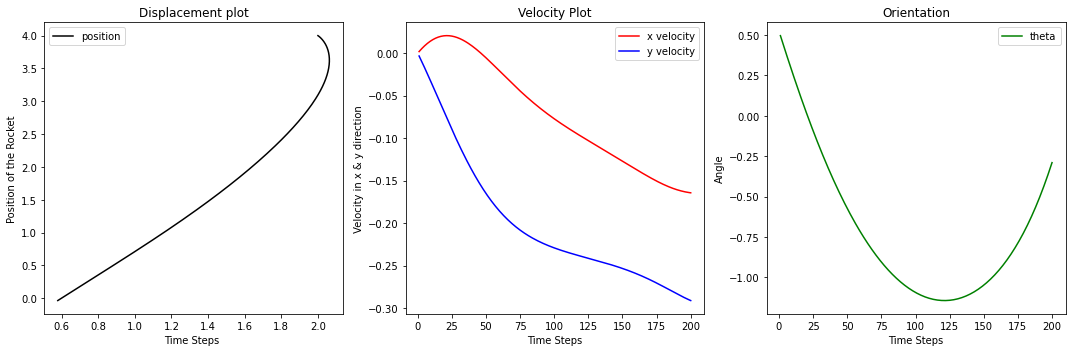

[11] loss: 0.452


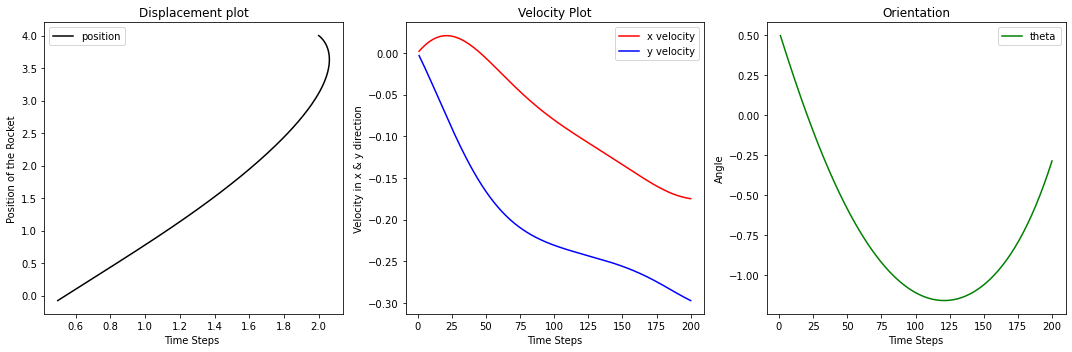

[12] loss: 0.399


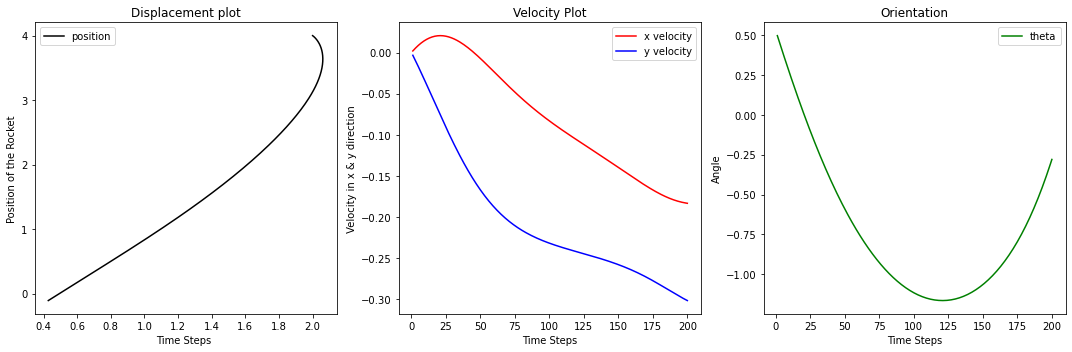

[13] loss: 0.362


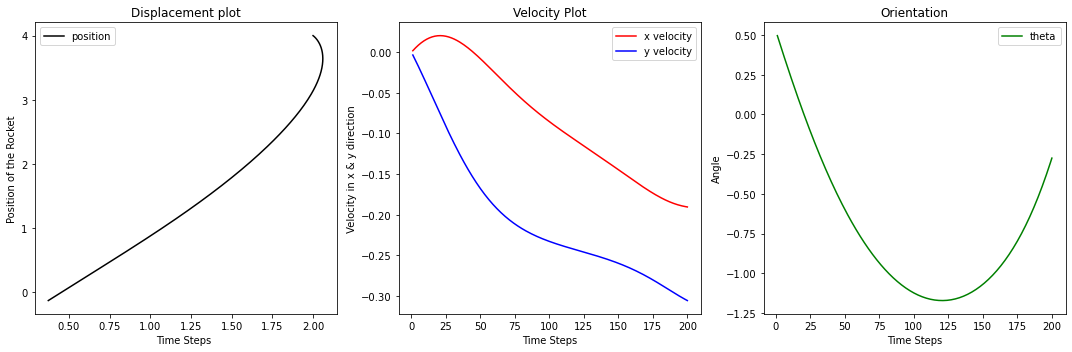

[14] loss: 0.337


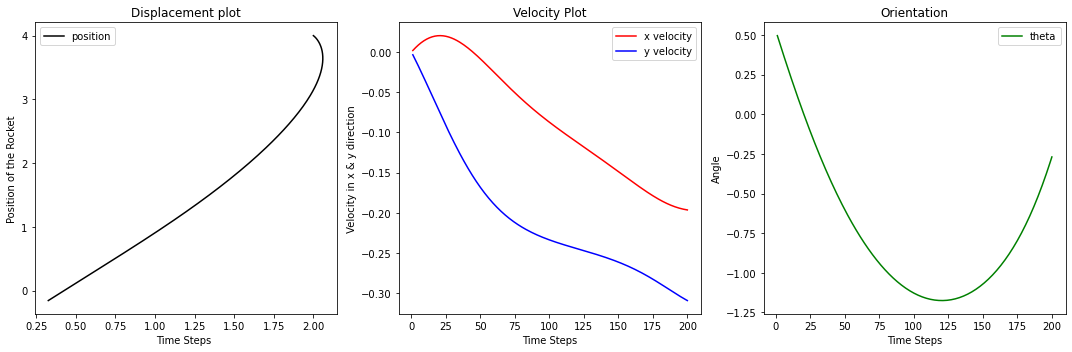

[15] loss: 0.319


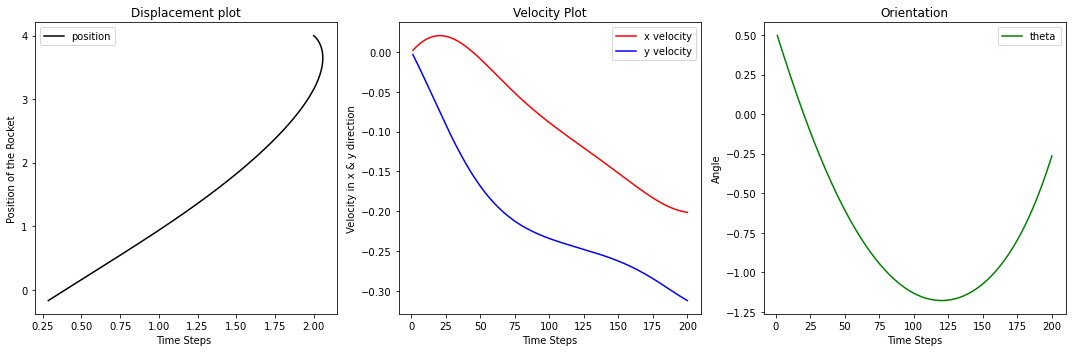

[16] loss: 0.305


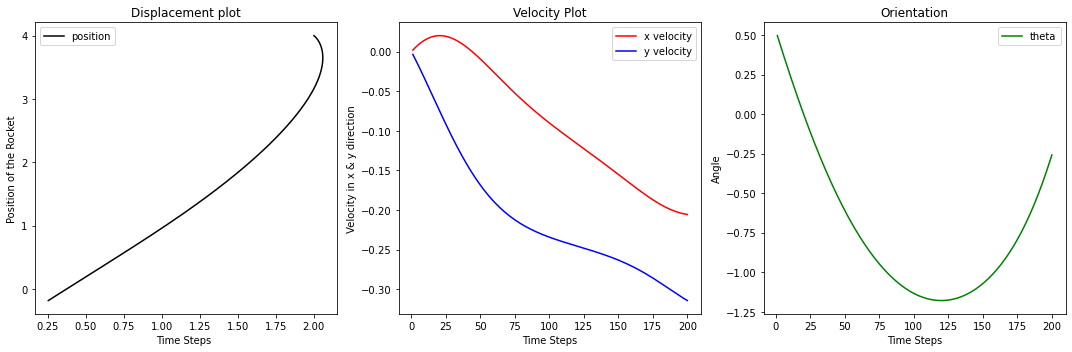

[17] loss: 0.294


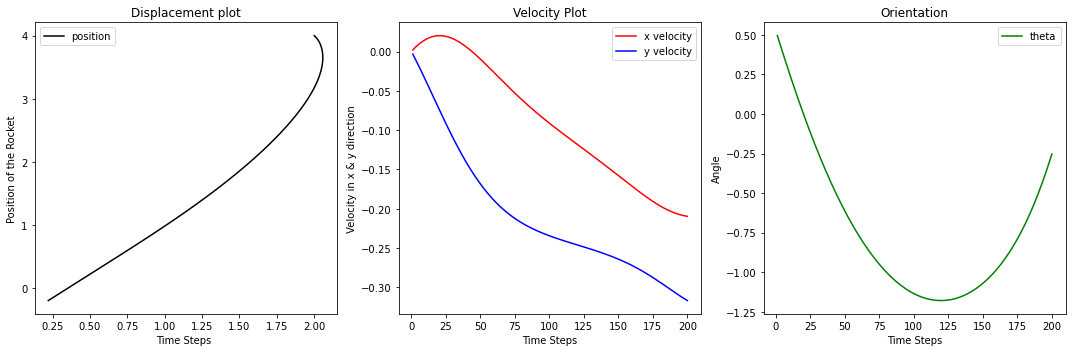

[18] loss: 0.283


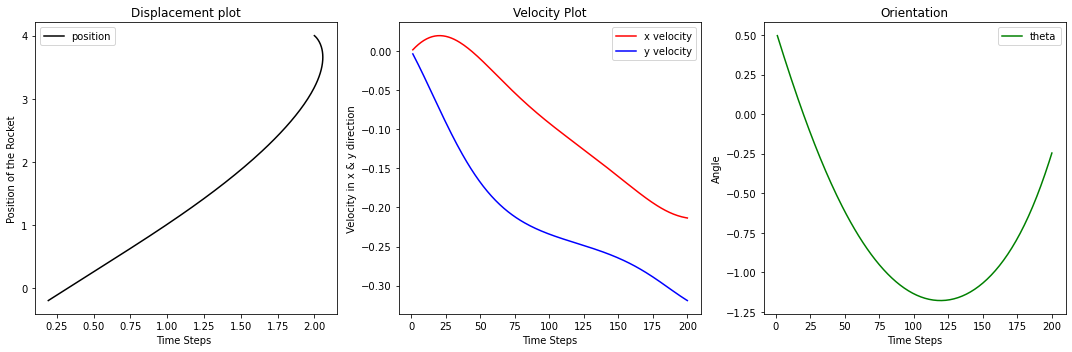

[19] loss: 0.273


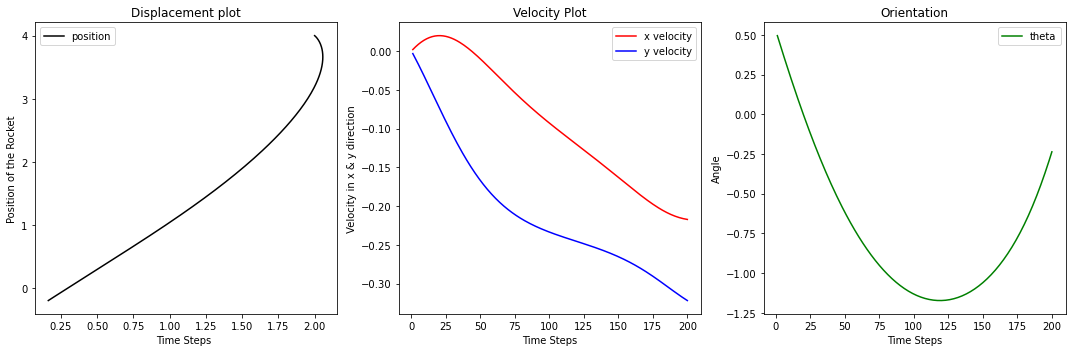

[20] loss: 0.259


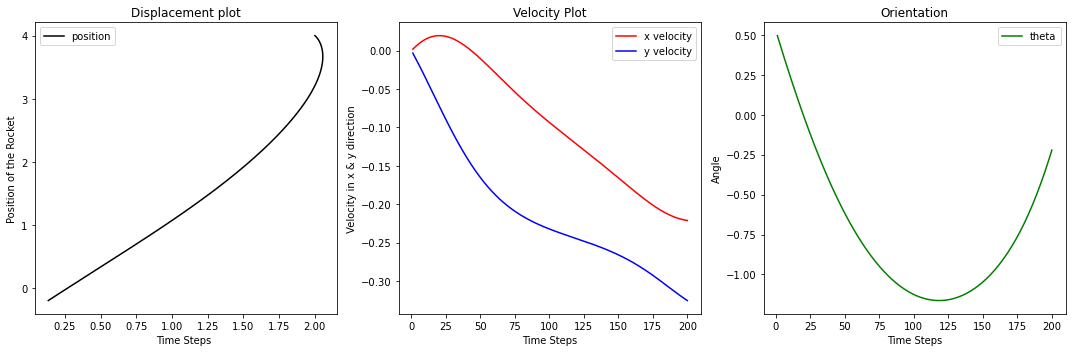

[21] loss: 0.239


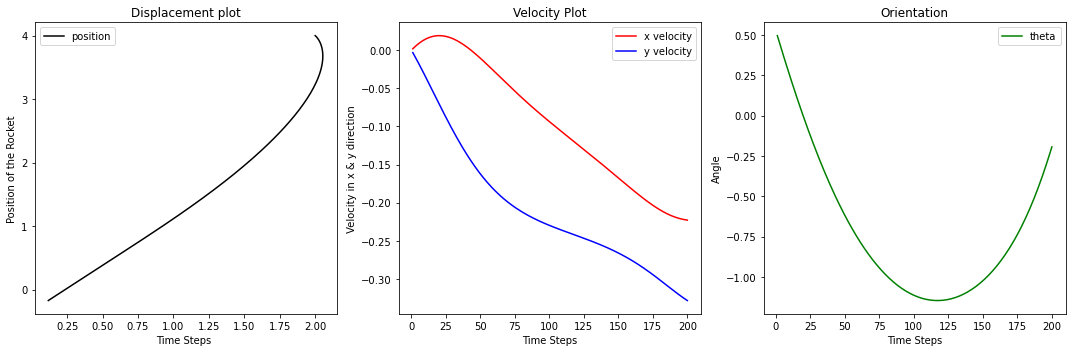

[22] loss: 0.188


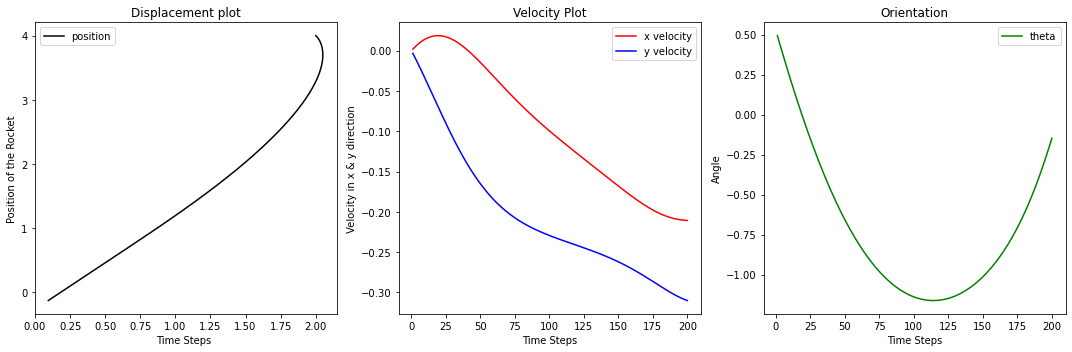

[23] loss: 0.119


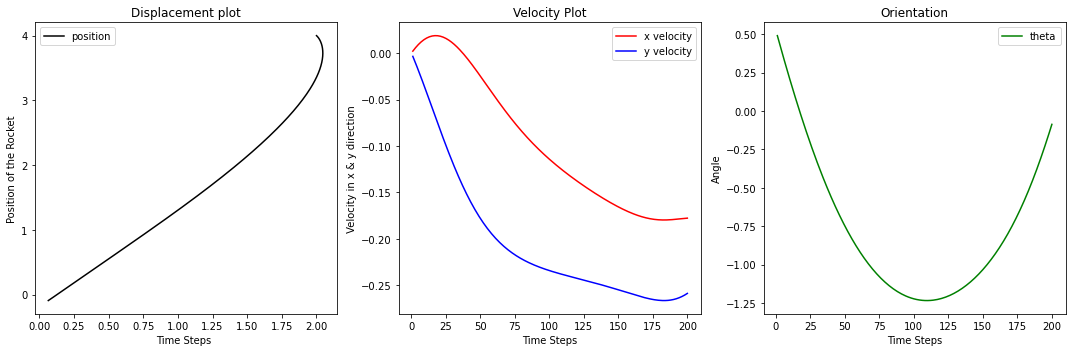

[24] loss: 0.067


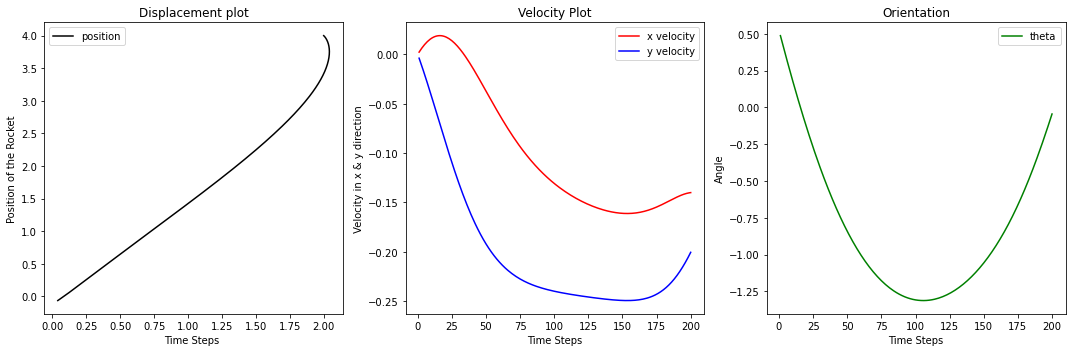

[25] loss: 0.039


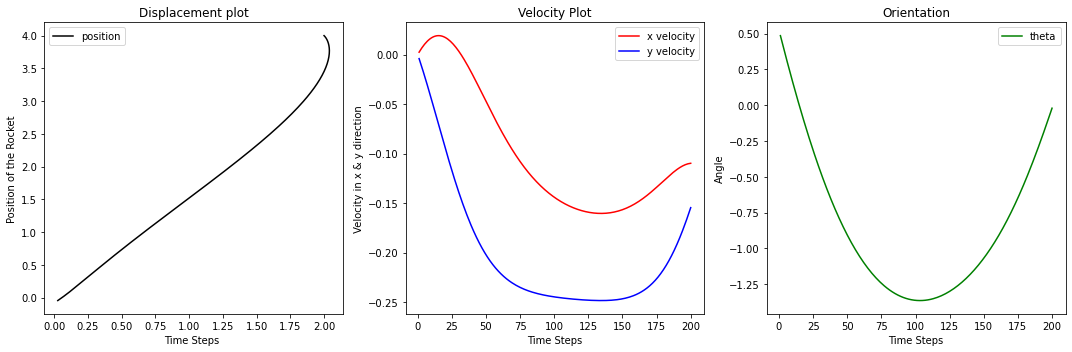

[26] loss: 0.023


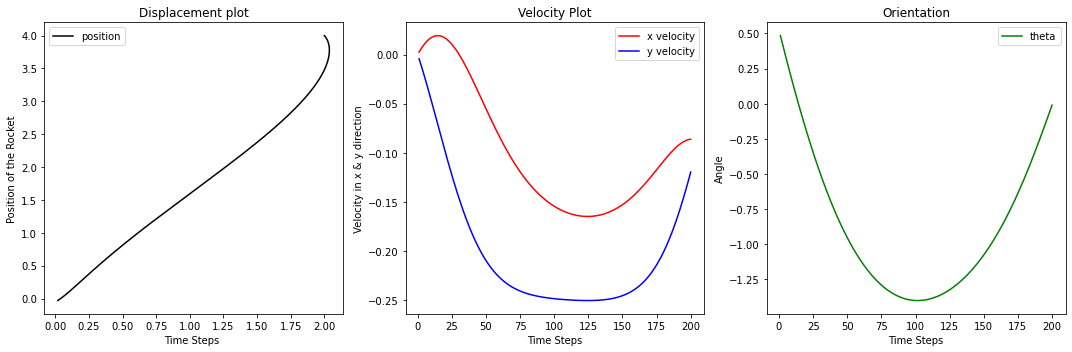

[27] loss: 0.014


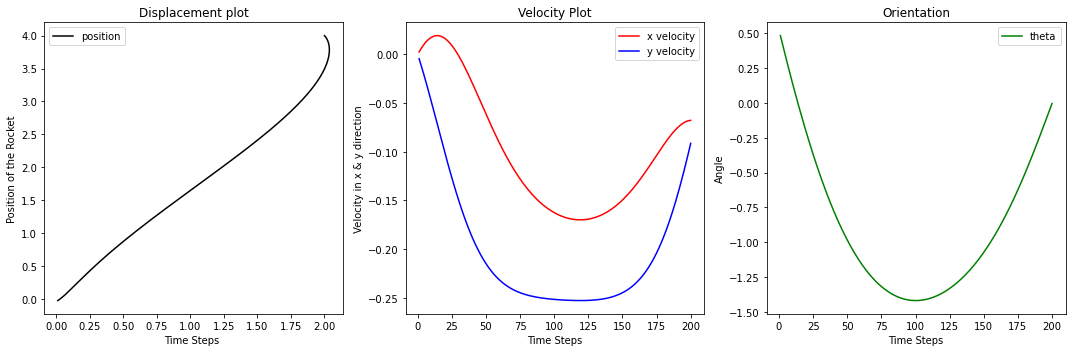

[28] loss: 0.008


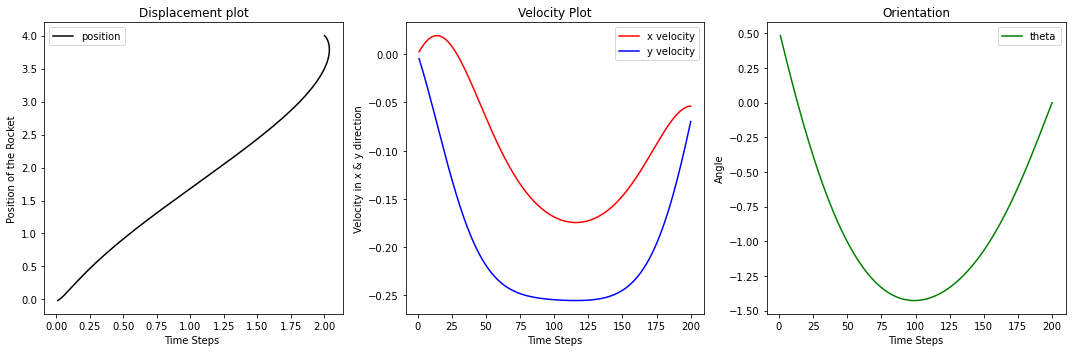

[29] loss: 0.005


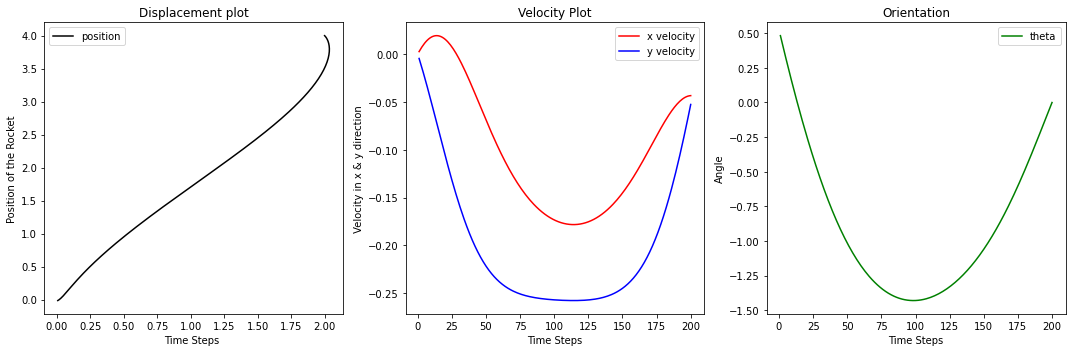

[30] loss: 0.003


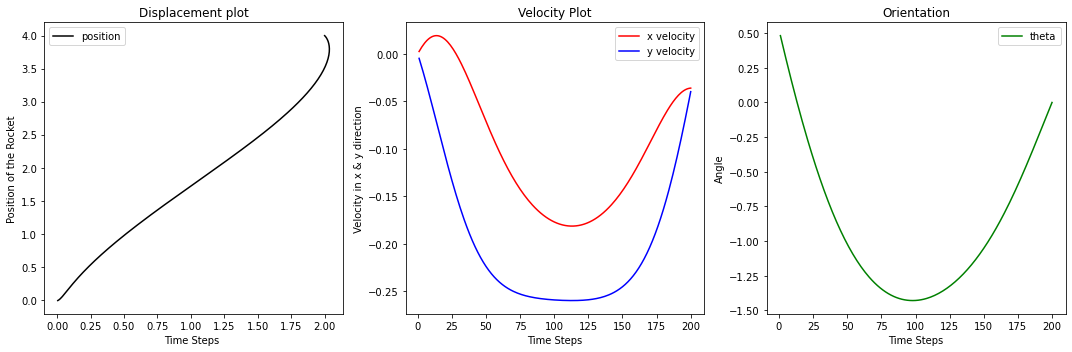

[31] loss: 0.002


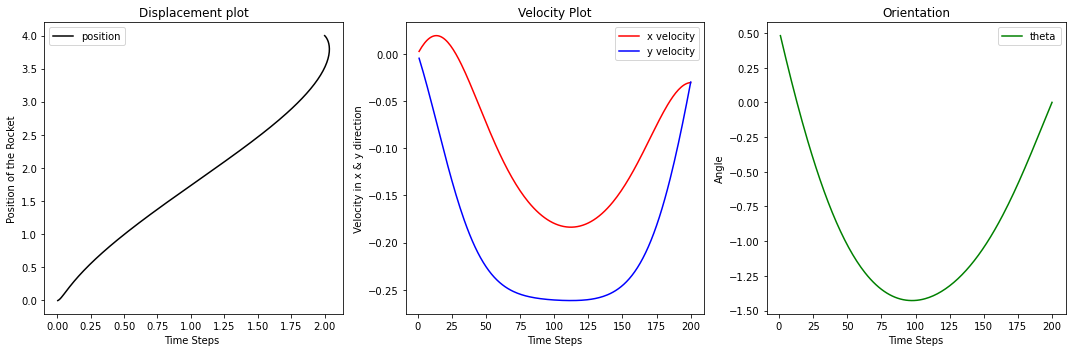

[32] loss: 0.001


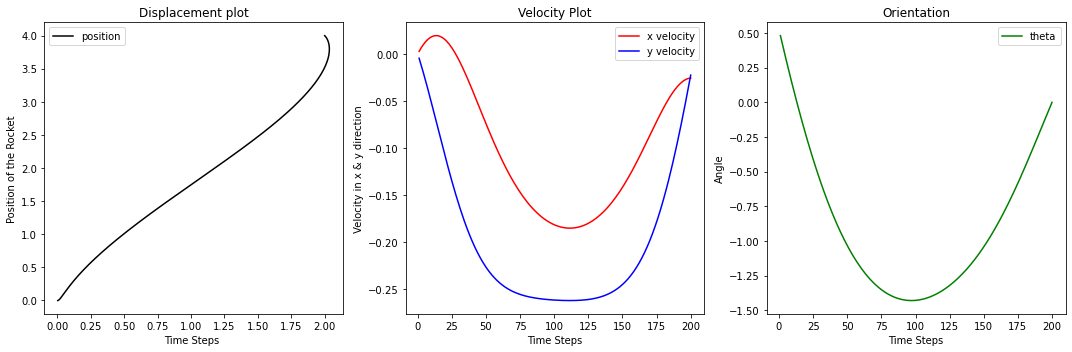

[33] loss: 0.001


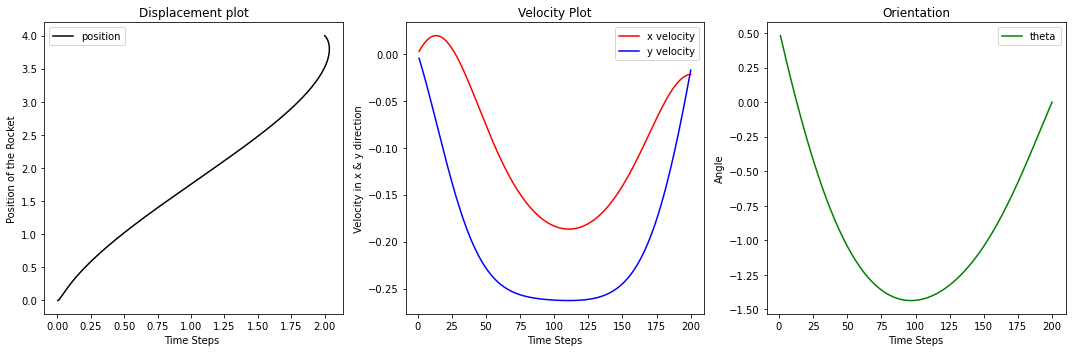

[34] loss: 0.001


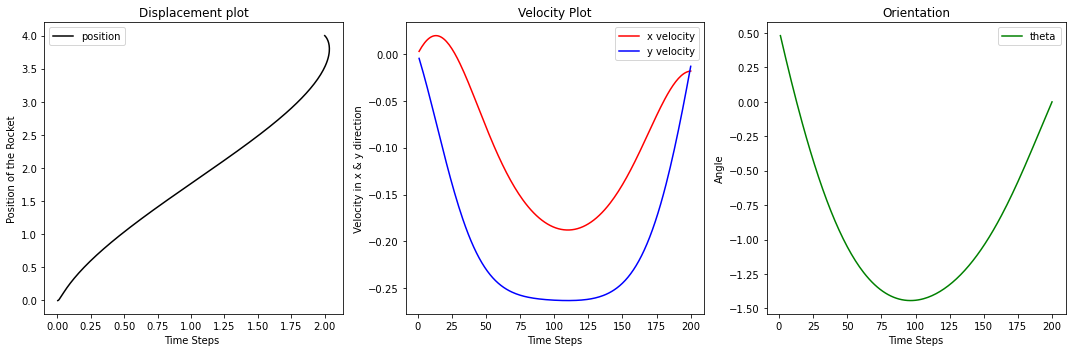

[35] loss: 0.000


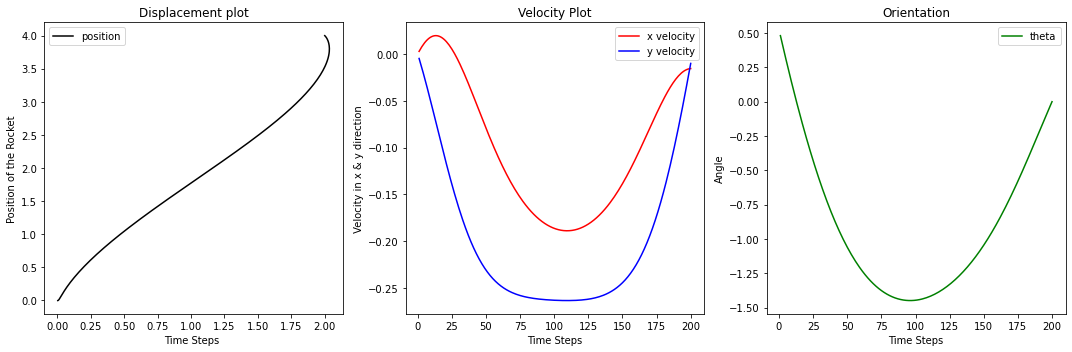

[36] loss: 0.000


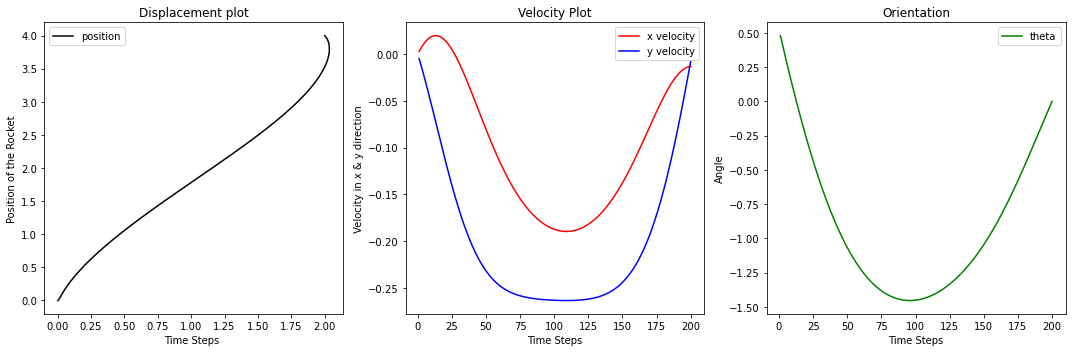

[37] loss: 0.000


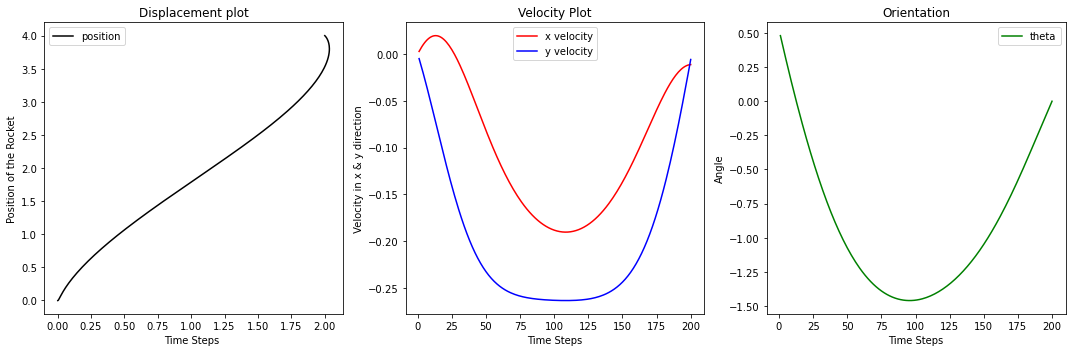

[38] loss: 0.000


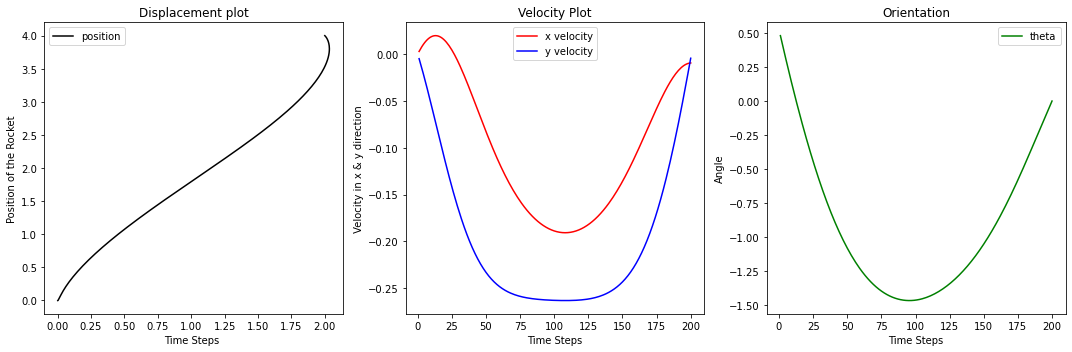

[39] loss: 0.000


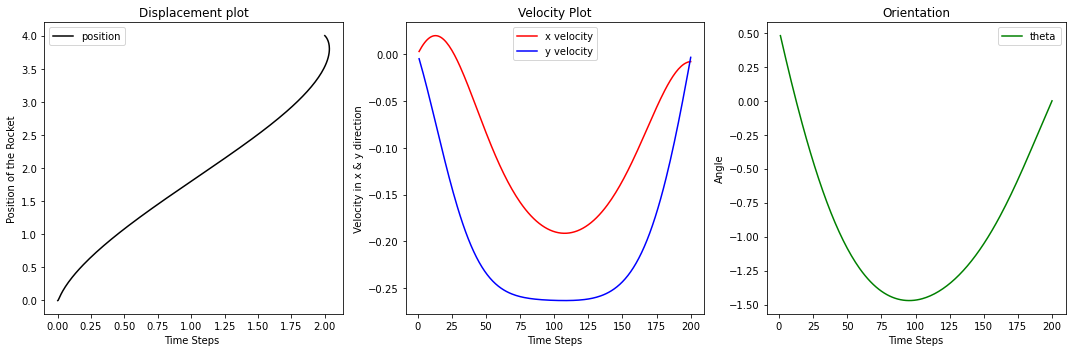

[40] loss: 0.000


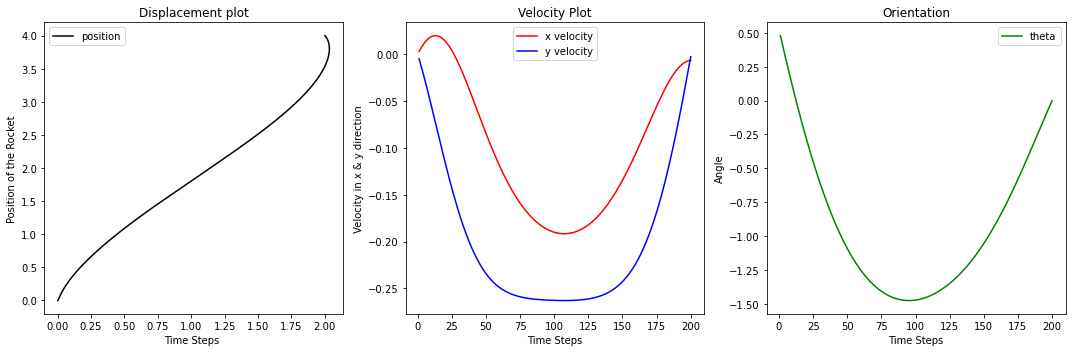

[41] loss: 0.000


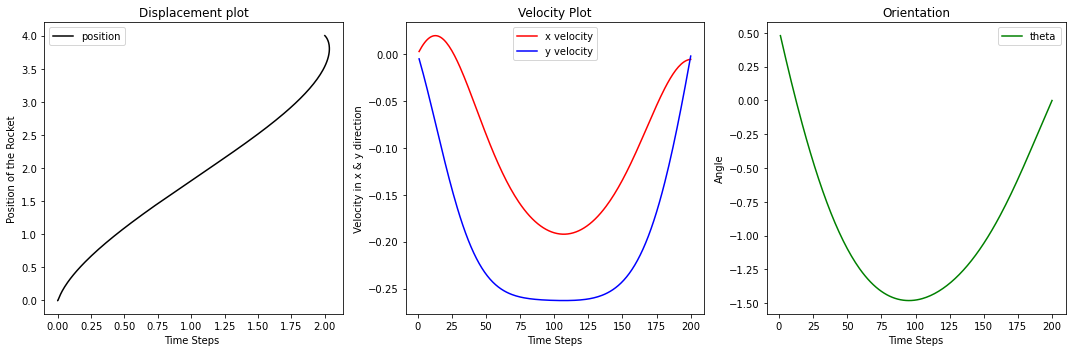

[42] loss: 0.000


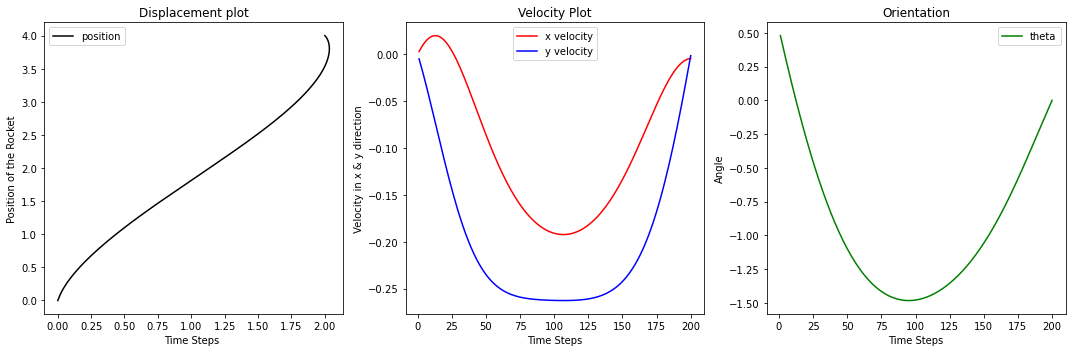

[43] loss: 0.000


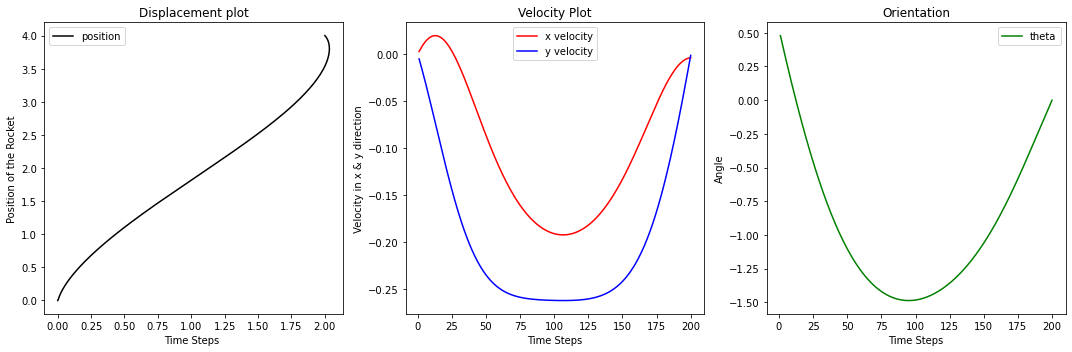

[44] loss: 0.000


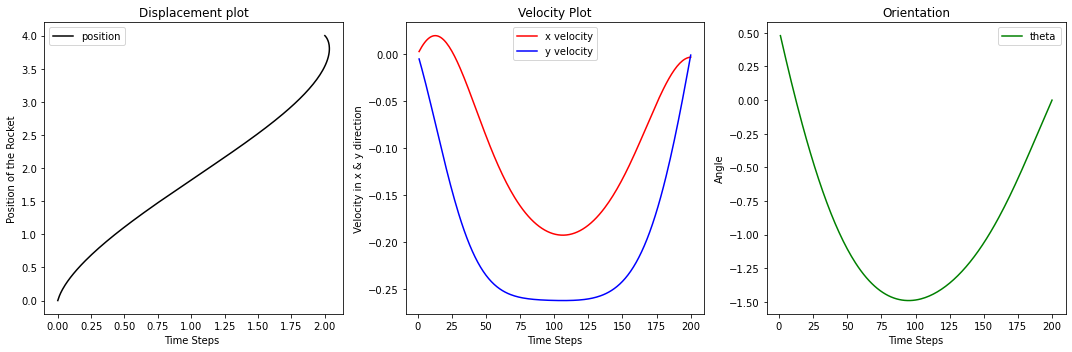

[45] loss: 0.000


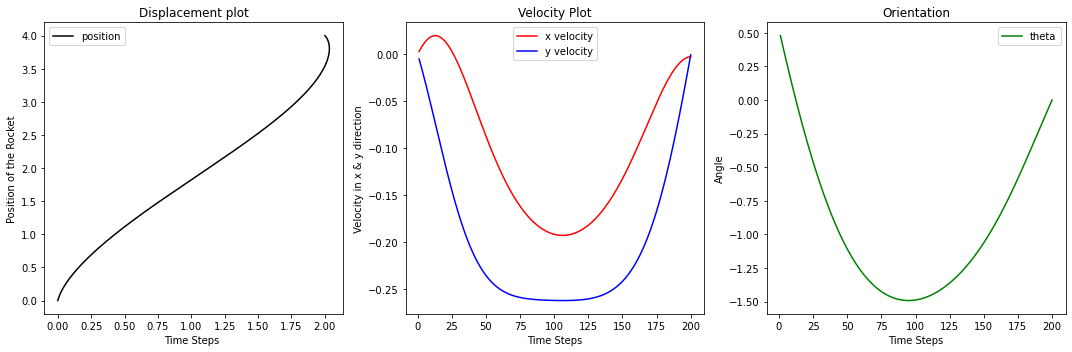

[46] loss: 0.000


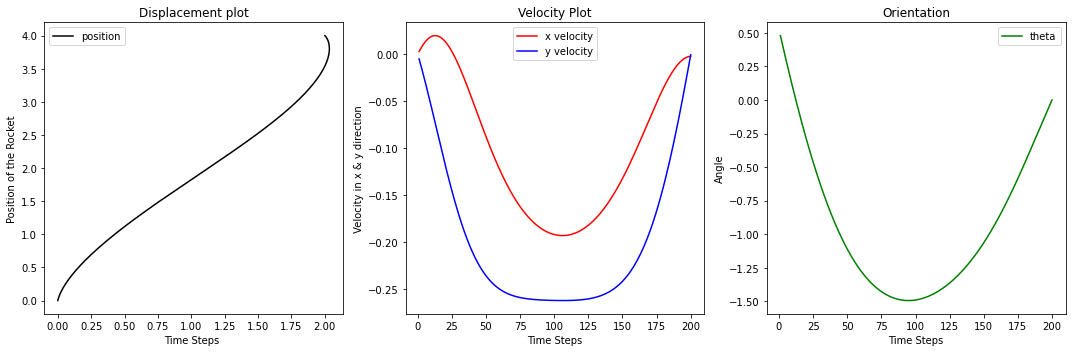

[47] loss: 0.000


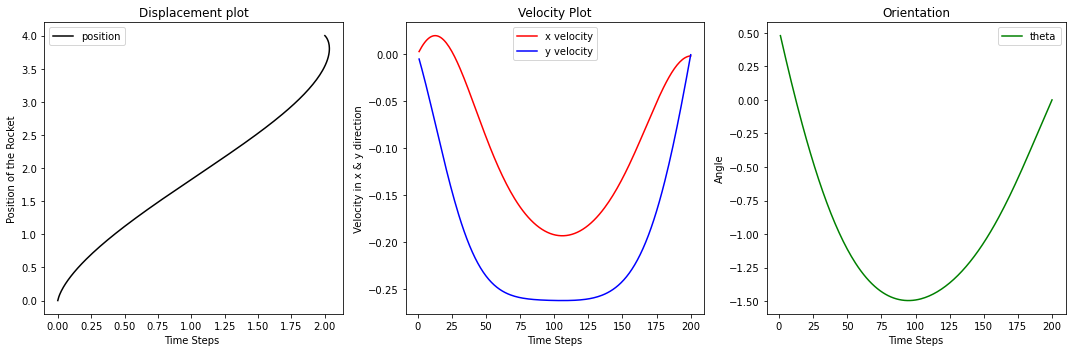

[48] loss: 0.000


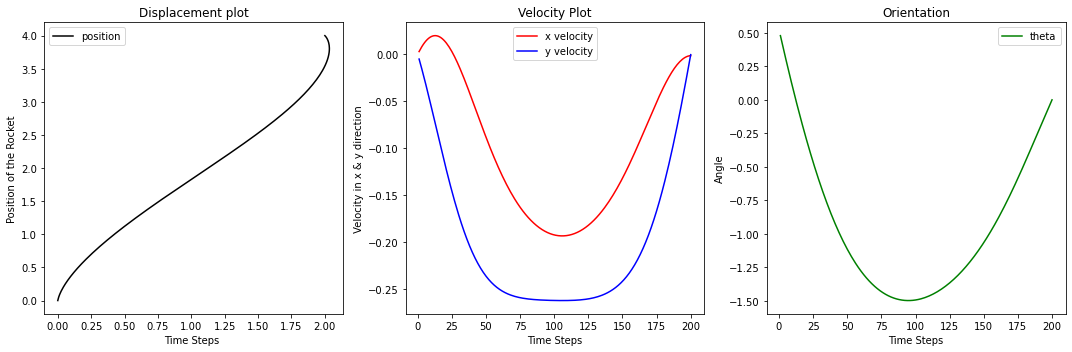

[49] loss: 0.000


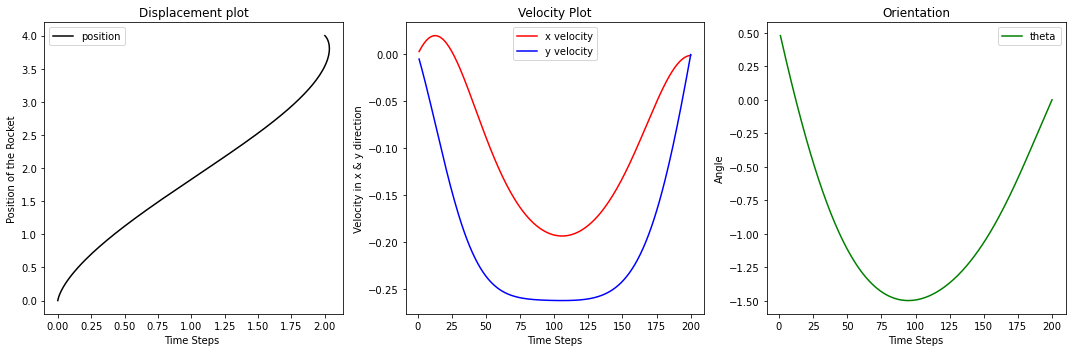

[50] loss: 0.000


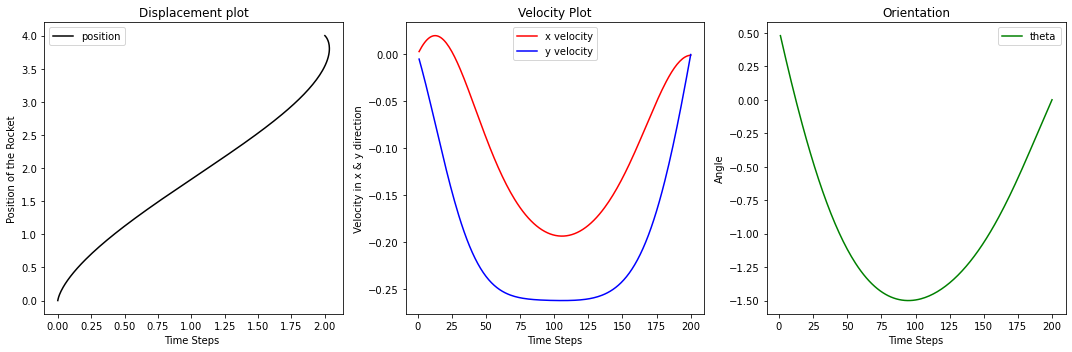

[51] loss: 0.000


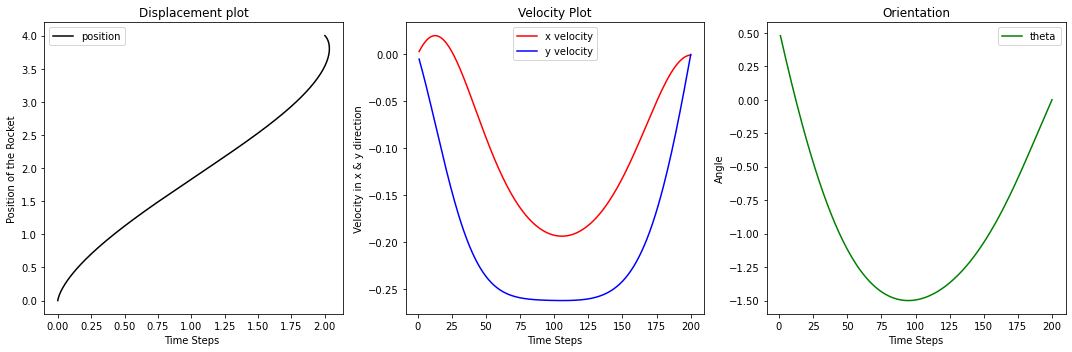

[52] loss: 0.000


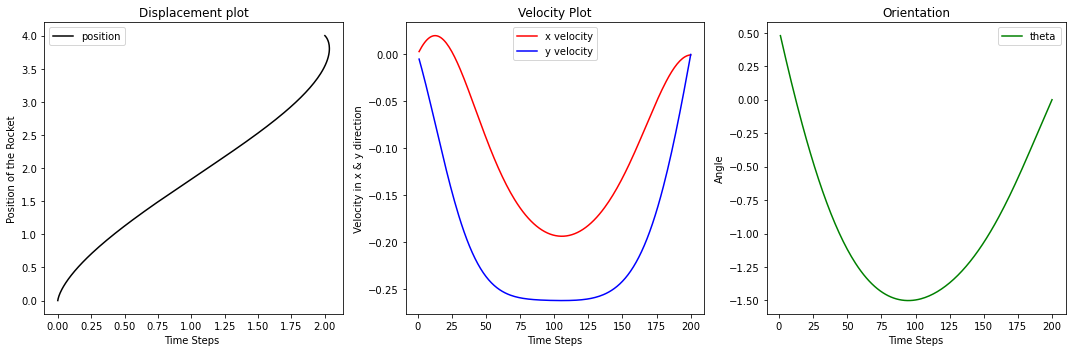

[53] loss: 0.000


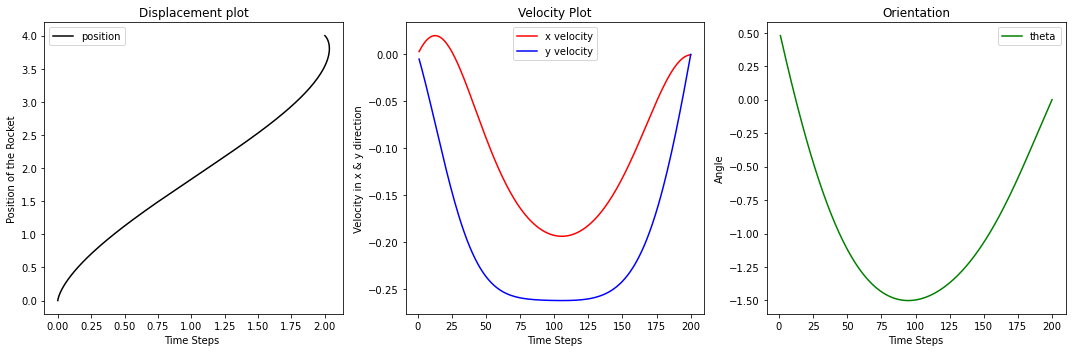

[54] loss: 0.000


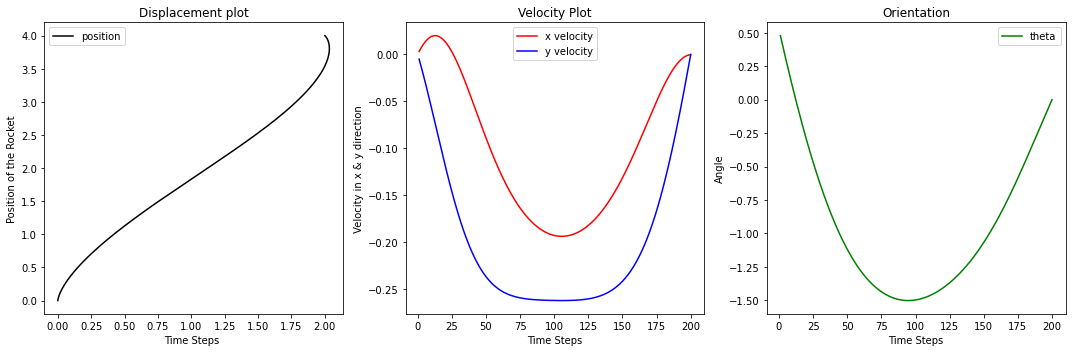

[55] loss: 0.000


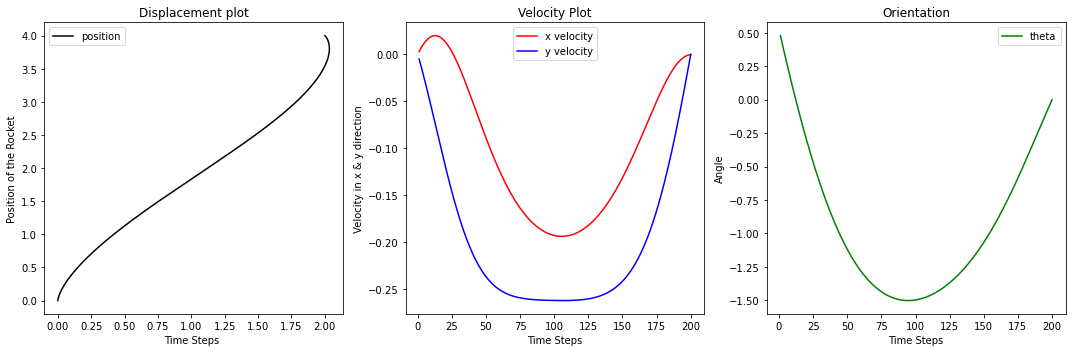

[56] loss: 0.000


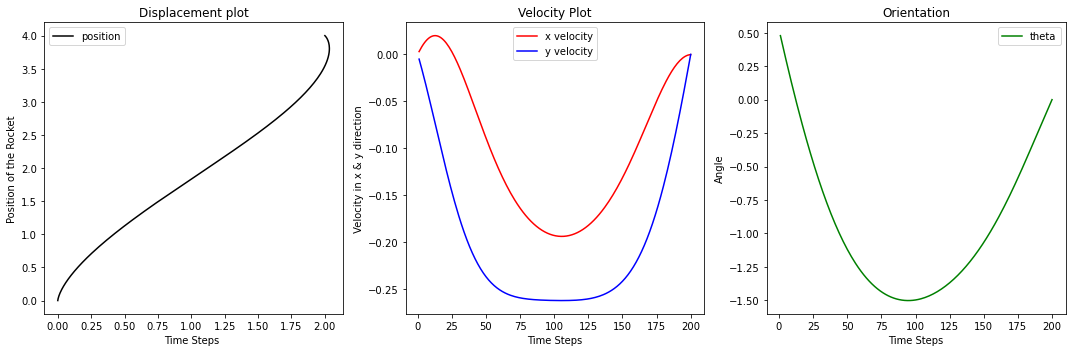

[57] loss: 0.000


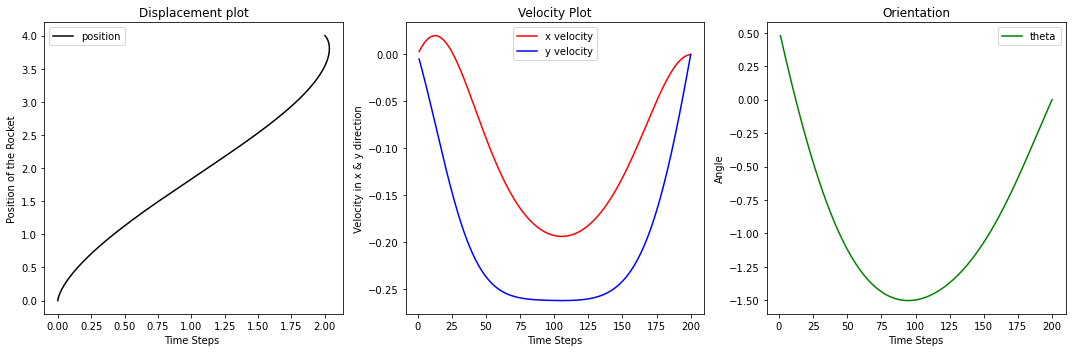

[58] loss: 0.000


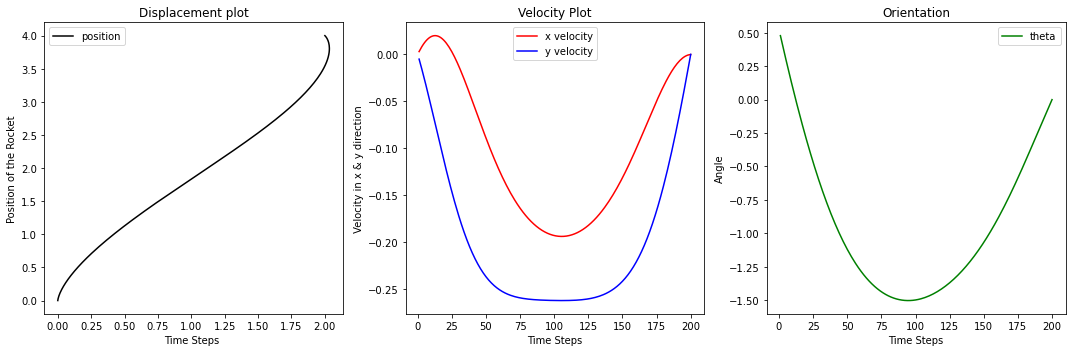

[59] loss: 0.000


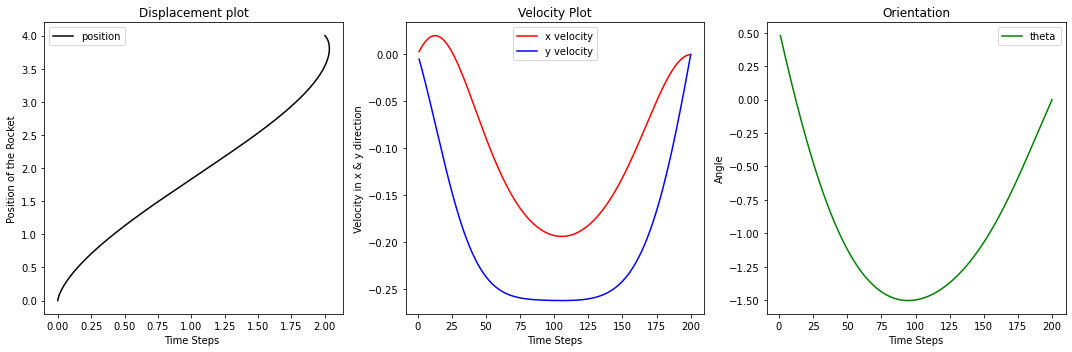

[60] loss: 0.000


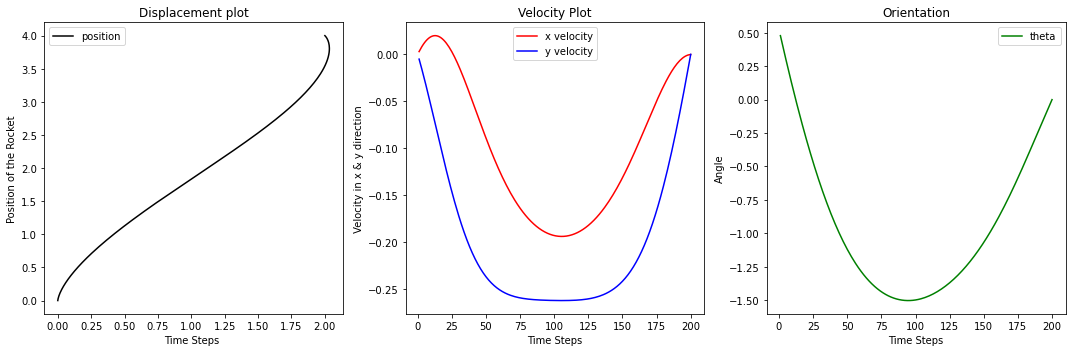

[61] loss: 0.000


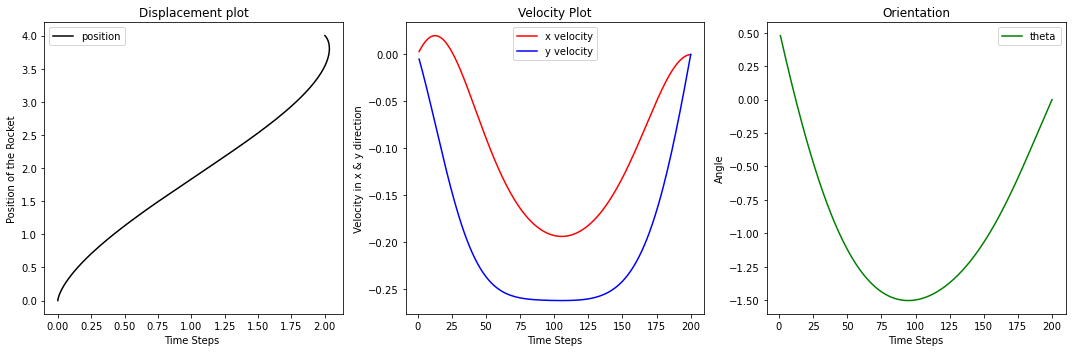

[62] loss: 0.000


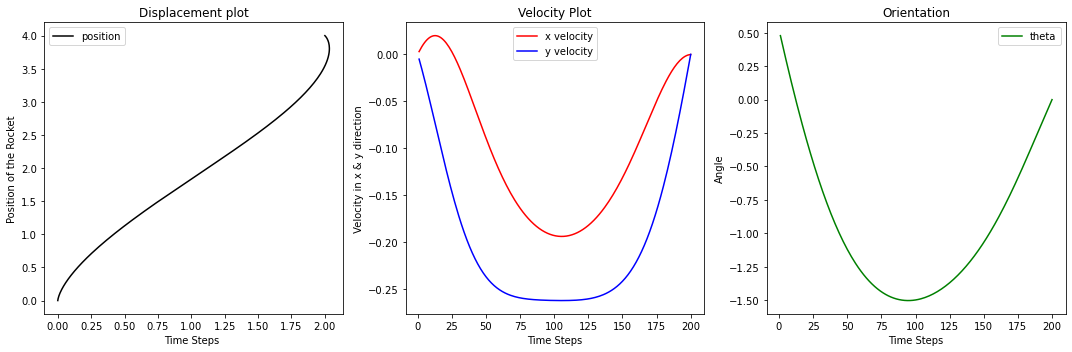

[63] loss: 0.000


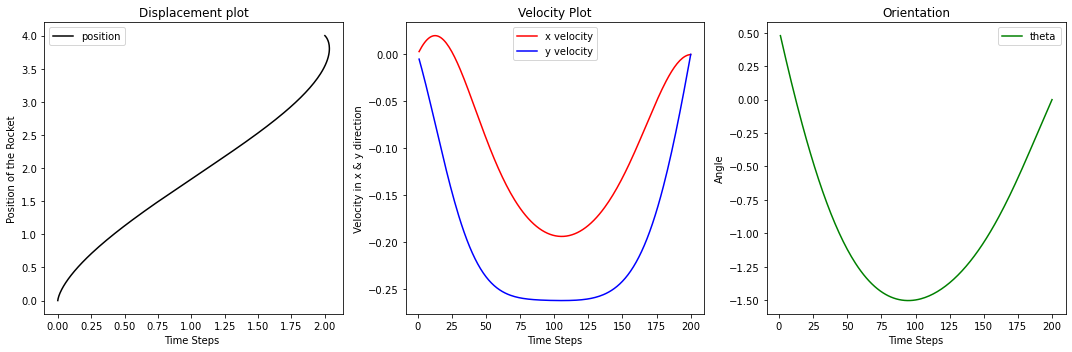

[64] loss: 0.000


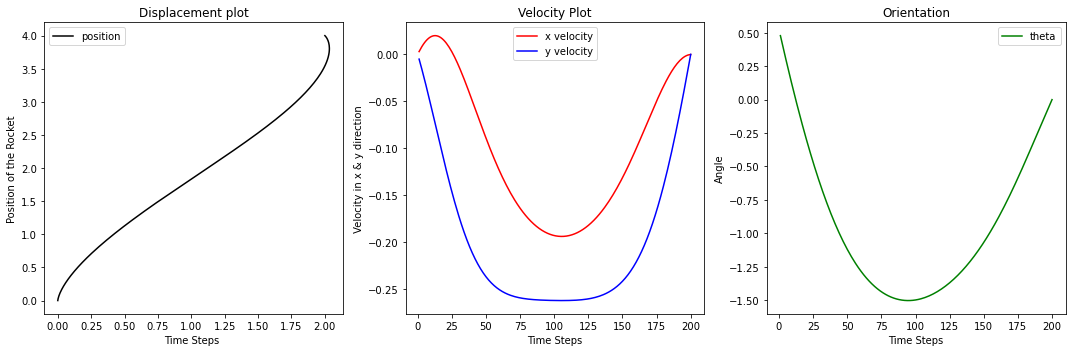

[65] loss: 0.000


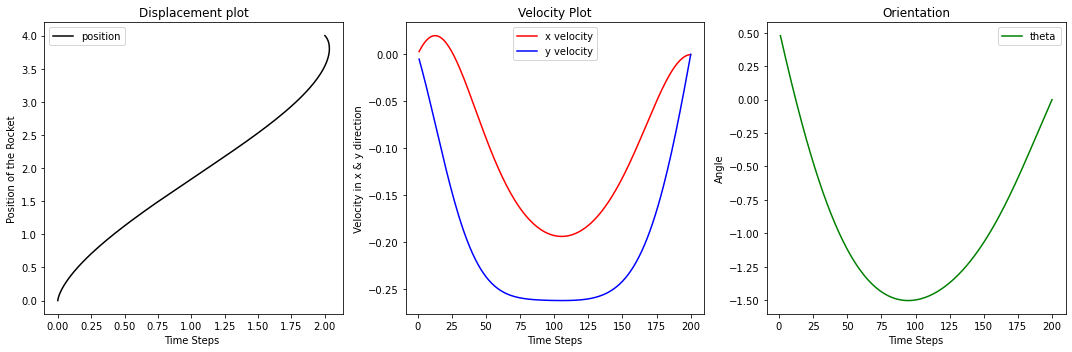

[66] loss: 0.000


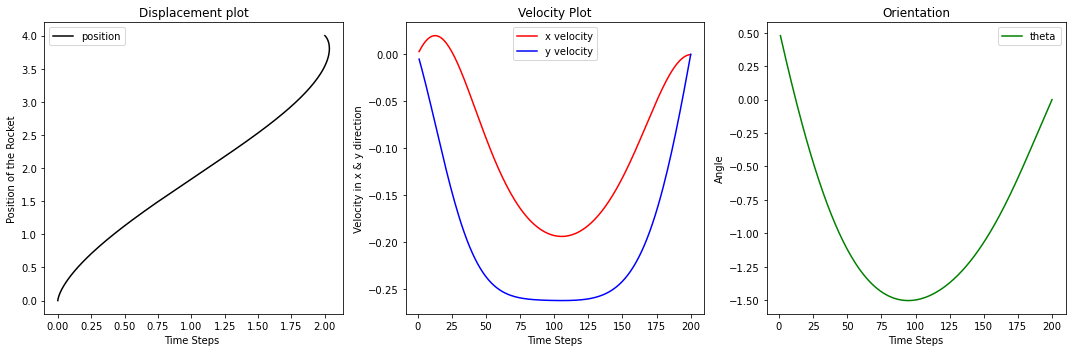

[67] loss: 0.000


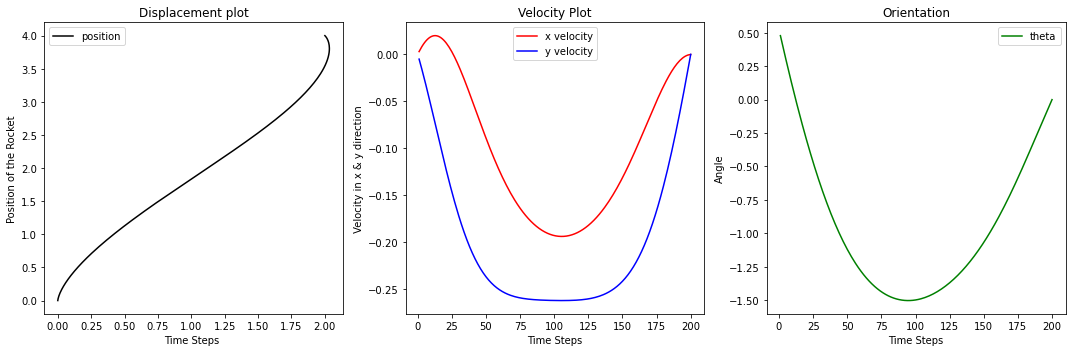

[68] loss: 0.000


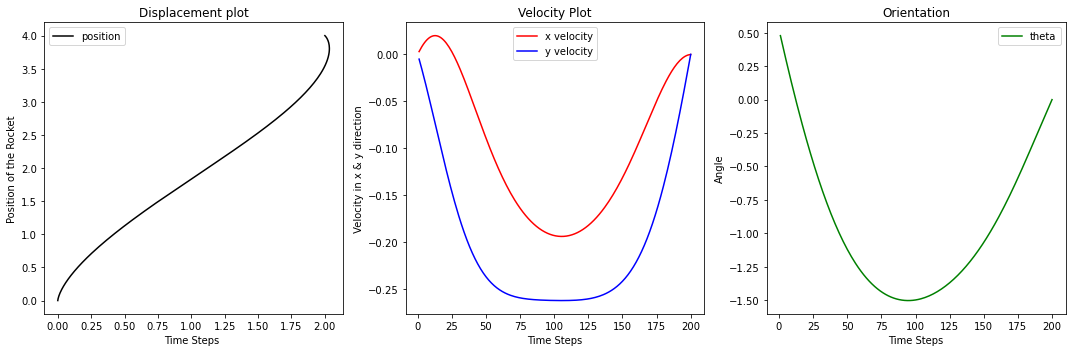

[69] loss: 0.000


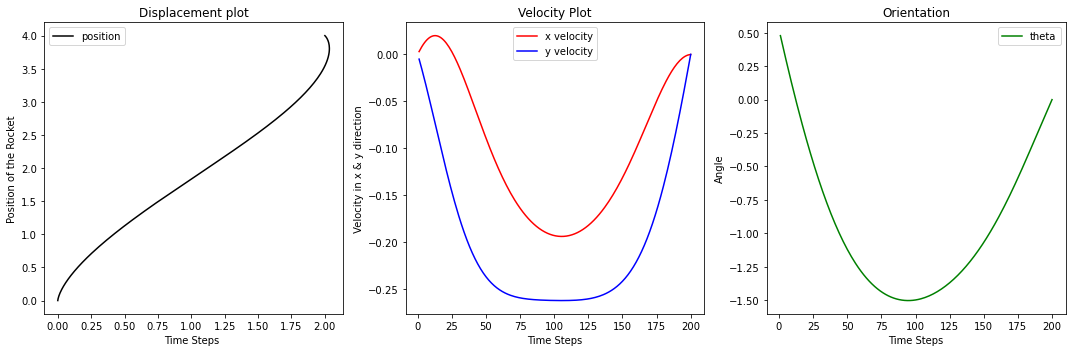

[70] loss: 0.000


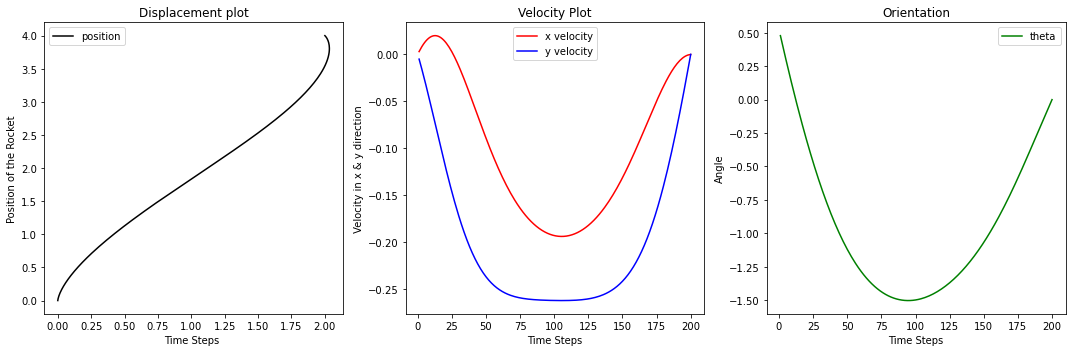

In [7]:

np.random.seed(1)
t.manual_seed(1)

T = 200                                            # number of time steps (So, requiring a total time of 20 seconds)
dim_input = 5                                      # state space dimensions
dim_hidden = 7                                     # latent dimensions
dim_output = 2                                     # action space dimensions
d = Dynamics()                                     # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)                            # define simulation
o = Optimize(s)                                    # define optimizer
o.train(70)                                       # solve the optimization problem

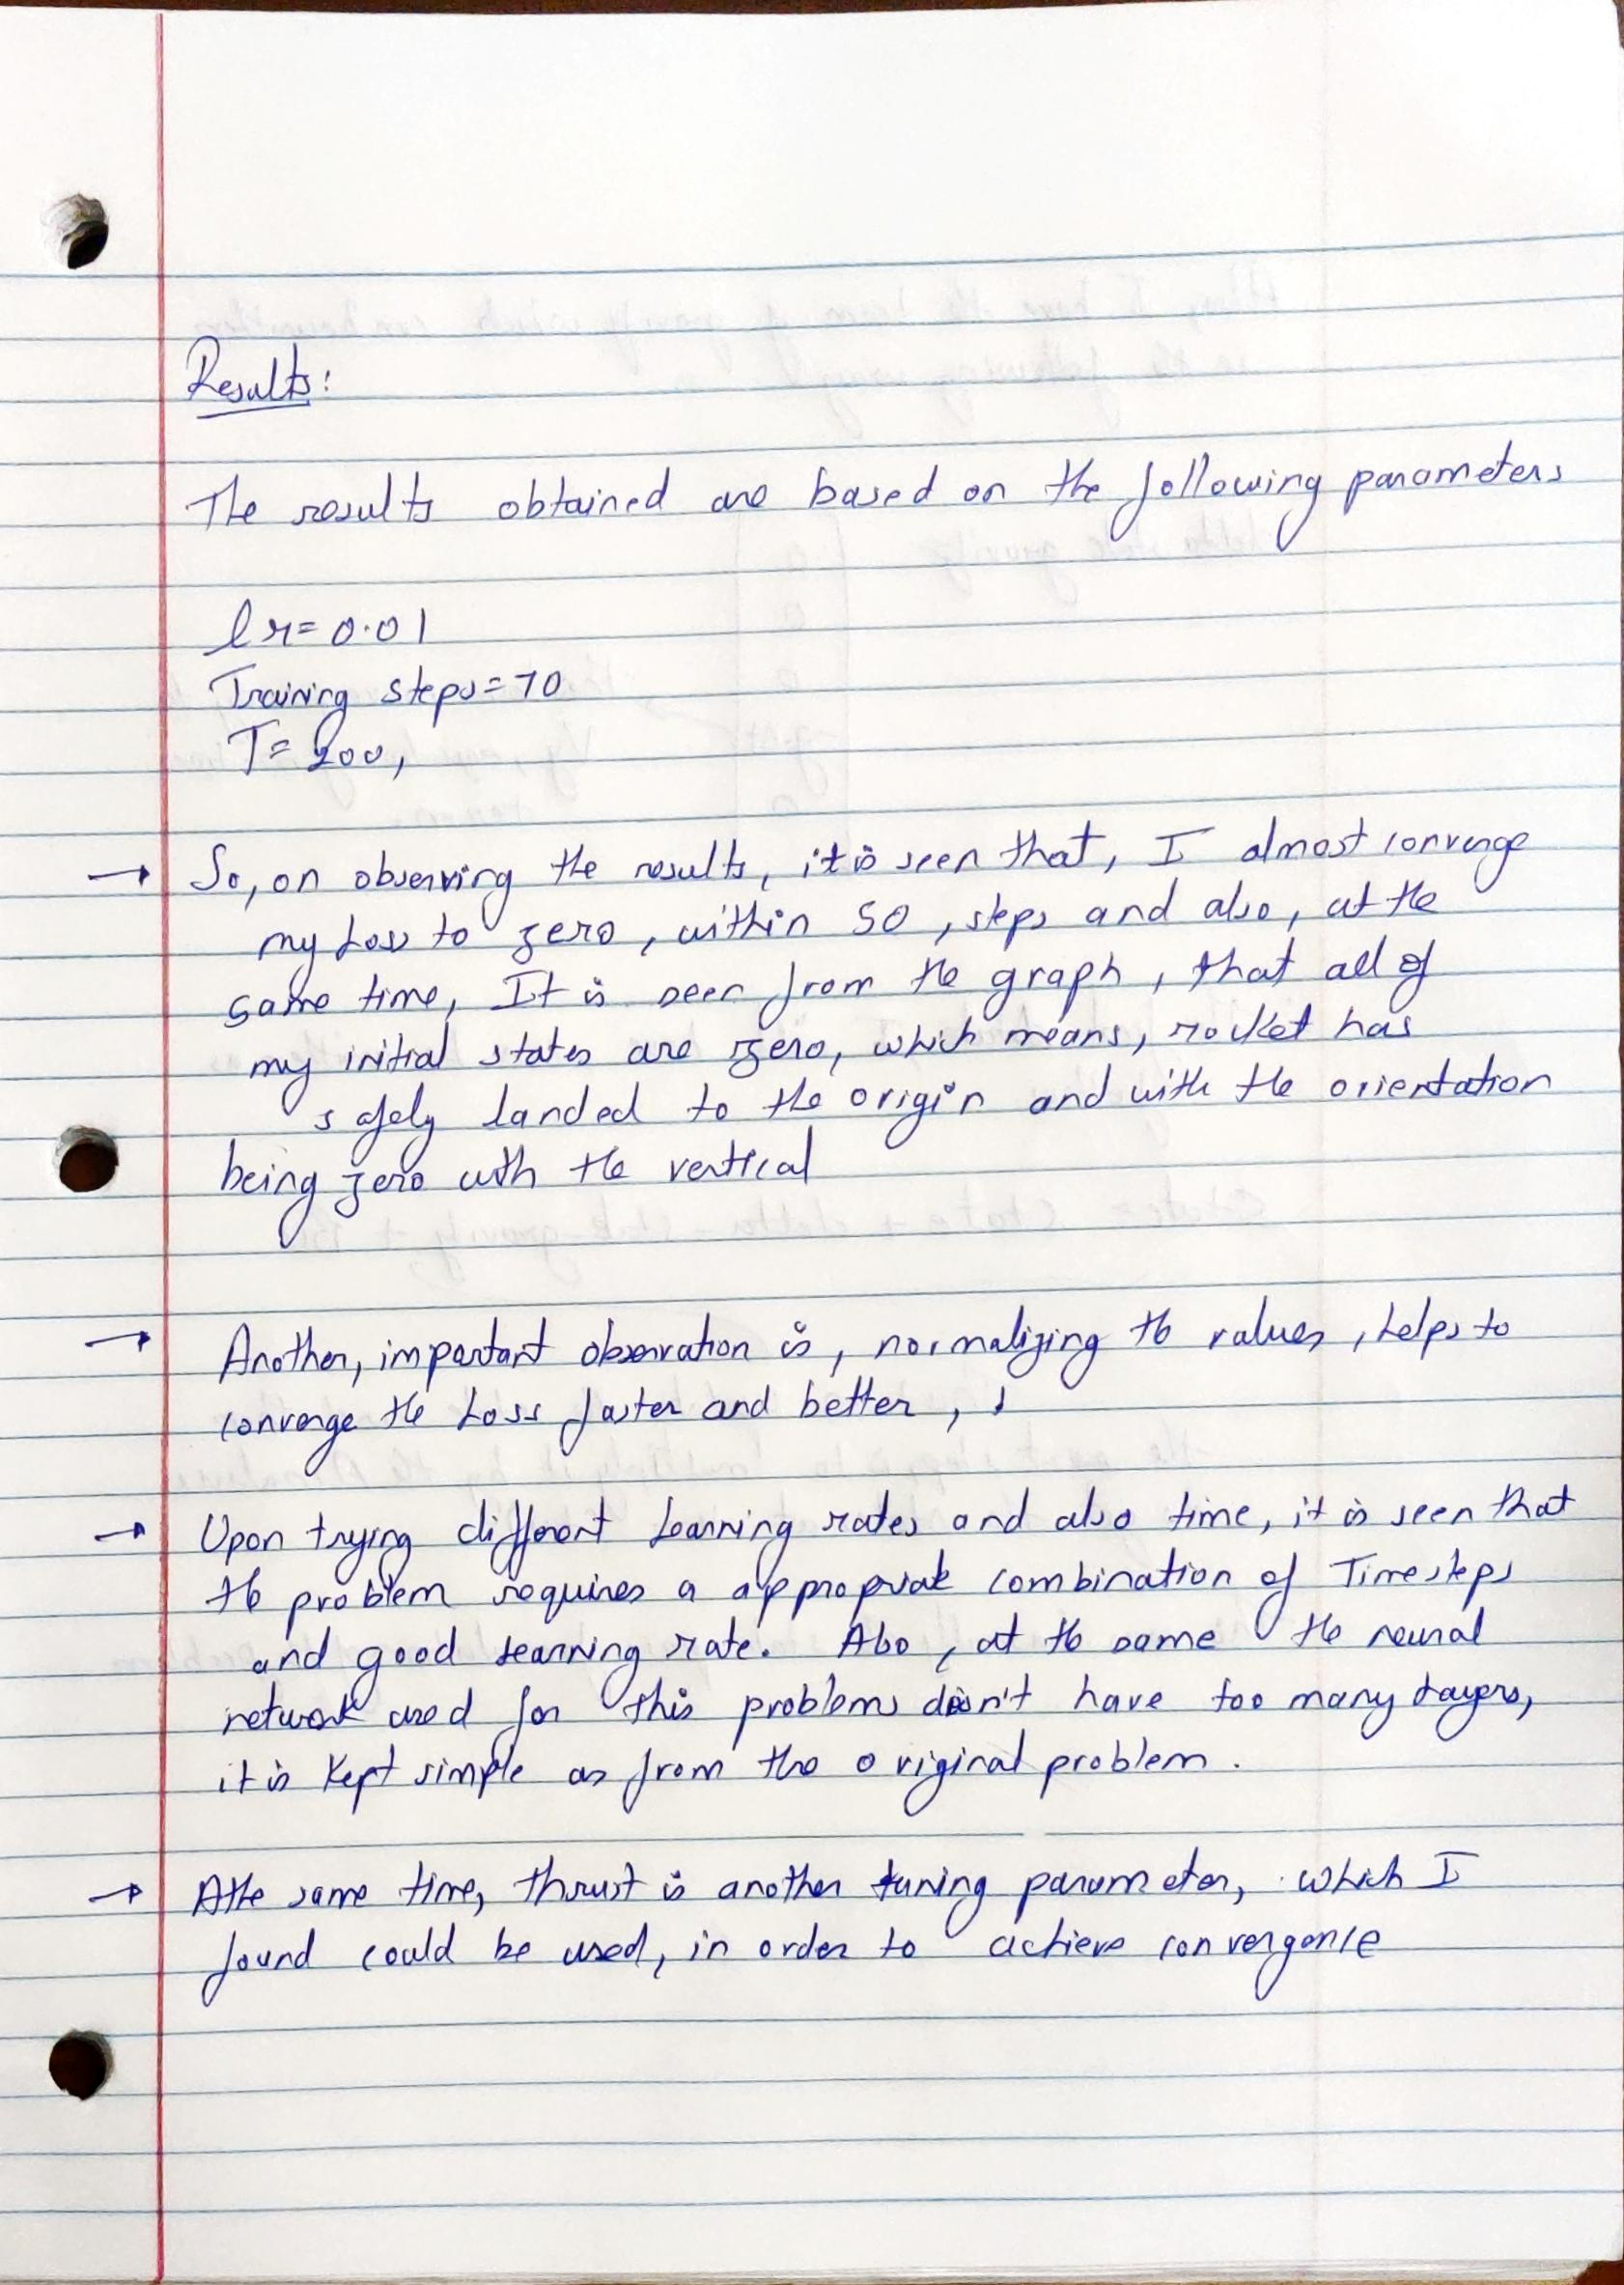